<div style="border:solid green 2px; padding: 20px">
    
<b>Артем, привет!</b> Мы рады тебя видеть на территории код-ревьюеров 😎. Ты проделал большую работу над проектом, но давай познакомимся и сделаем его еще лучше! У нас тут своя атмосфера и несколько правил:


1. Меня зовут Александр Матвеевский. Я работаю код-ревьюером, моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе стать дата-специалистом.
2. Общаемся на ты.
3. Если хочешь написать, спросить - не нужно стесняться. Только выбери свой цвет для комментария.  
4. Это учебный проект, тут можно не бояться сделать ошибку.  
5. У нас с тобой 6 попыток для сдачи проекта.  
6. Let's Go!

---

Я буду красить комментарии цветом, пожалуйста, не удаляй их:

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

Такой комментарий нужно исправить обязательно, он критически влияет на удачное выполнение проекта.
</div>
    
---

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__


Такой комментарий является рекомендацией или советом. Можешь использовать их на своё усмотрение.
</div>

---

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Такой комментарий  говорит о том, что было сделано что-то качественное и правильное =)
</div>
    
---
    
Предлагаю работать над проектом в диалоге: если ты что-то меняешь в проекте или отвечаешь на мои комментарии — пиши об этом. Мне будет легче отследить изменения, если ты выделишь свои комментарии:   
    
<div class="alert alert-info"> <b>Комментарии студента:</b> Например, вот так.</div>
    
Всё это поможет выполнить повторную проверку твоего проекта оперативнее. Если будут какие-нибудь вопросы по моим комментариям, пиши, будем разбираться вместе :)    
    
---

# Проект: Анализ лояльности пользователей Яндекс Афиши

Выполнил: Васин Артём Александрович

Дата: 

Ссылка на репозиторий: https://github.com/artemvasin86-netizen/yandex_afisha_analysis.git

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__


Важно убрать чувствительные данные (логины, пароли). Ниже проекта об этом описал
    


## Основная цель проекта: провести исследовательский анализ данных для отдела маркетинга, чтобы выявить закономерности в поведении пользователей.

## Описание:

1. Загрузка данных 

2. Знакомство с данными

3. Предобработка данных

4. Создание профиля пользователя

5. Исследовательский анализ данных
   
   5.1 Исследование признаков первого заказа и их связи с возвращением на платформу
   
   5.2 Исследование поведения пользователей через показатели выручки и состава заказа
   
   5.3 Исследование временных характеристик первого заказа и их влияния на повторные покупки
   
   5.4 Корреляционный анализ количества покупок и признаков пользователя
   
6. Общие выводы и рекомендации

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
    
Здорово, что оставляешь вводную часть! Она помогает быстро понять цель, контекст и структуру работы, что будет удобно не только для тебя при возвращении к проекту спустя время, но и любому другому читателю (если, например, публикуешь в открытый доступ для портфолио). Воспринимаем эту тетрадку не просто как выполнение домашней работы на курсе, а как полноценный исследовательский проект.

Как правило, в вводную часть включают название проекта, краткое описание цели, используемых данных (источники, объем, особенности), нюансы самого проекта (специфические условия, ограничения, предположения и т.д.). Иногда также сразу обозначают план шагов. Другими словами, вводная часть призвана отразить, что мы делаем, с чем работаем и на каких условиях.
</div>

# 1. Загрузка данных

## Подключение к базе данных с помощью Python

**Устанавливаем библиотеку sqlalchemy**

In [1]:
!pip install sqlalchemy

***Установка модуля psycopg2***

In [2]:
!pip install psycopg2

**Устанавливаем библиотеку phik**

In [3]:
%pip install phik

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.


***Импортируем библиотеки***

In [5]:
import phik
from phik import resources, report
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Хорошо, что все импорты собраны в первой ячейке кода, это соответствует оформлению кода <a href='https://pyplanet.ru/article/pep-0008.html'>PEP 8</a> и помогает понять, какое окружение используется в проекте.

***Подключение к базе данных Практикума***

In [6]:
import os
from dotenv import load_dotenv
    
load_dotenv()
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PWD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
)

# Создаем объект engine
engine = create_engine(connection_string)

***Извлечение результатов SQL-запроса***

In [7]:
# Записываем SQL-запрос в переменную query
query = '''
SELECT user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    (p.created_dt_msk::date - LAG(p.created_dt_msk::date) OVER (PARTITION BY p.user_id ORDER BY p.created_dt_msk)) AS days_since_prev,
    p.event_id,
    e.event_type_main,
    p.service_name,
    r.region_name,
    c.city_name
FROM afisha.purchases AS p
JOIN afisha.events as e ON p.event_id = e.event_id
JOIN afisha.city AS c ON e.city_id = c.city_id
JOIN afisha.regions AS r ON r.region_id =c.region_id
WHERE device_type_canonical IN ('mobile', 'desktop') AND e.event_type_main != 'фильм'
ORDER BY user_id 
'''

In [8]:
# Выполненяем запрос и запись результата в датафрейм Pandas
df = pd.read_sql_query(query, con=engine)

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__


    

Сейчас ты явным образом прописываешь параметры подключения к БД. В таком виде выкладывать работу в публичный доступ небезопасно, кто-то сможет завладеть подключением, украсть или повредить данные. 
    
Чтобы засекретить подключение, необходимо сложить все параметры в `.env` файл (или другой конфигурационный файл вне Git) и указать его в `.gitignore`:

```python
DB_NAME="..."
DB_HOST="..."
DB_PORT="..."
DB_USER="..."
DB_PASSWORD="..."
```
    
В самом проекте мы можем обращаться к сохраненным параметрам, для этого нам потребуются библиотеки `dotenv`, чтобы загрузить переменные окружения, и `os`, чтобы обратиться к ним:
    
```python
import os
import dotenv
    
load_dotenv() # автоматически ищет .env в текущей директории
    
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    os.getenv('DB_USER'),
    os.getenv('DB_PASSWORD'),
    os.getenv('DB_HOST'),
    os.getenv('DB_PORT'),
    os.getenv('DB_NAME'),
) 
```
    
<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
На гитхабе так нужно организовать обязательно, для принятия проекта.    

<div class="alert alert-info"> <b>Комментарий студента:</b> Исправил хранение данных. Теперь логин и пароль не прописаны в коде, а выгружаются из окружения.</div>

# 2. Знакомство с данными

### Выведем для ознакомление первые строки датафрейма

In [9]:
df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,стендап,Билеты без проблем,Озернинский край,Родниковецк


### Выведем общую информацию о датафрейме

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_type_main        290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  region_name            290611 non-null  obje

Общая информация о данных:

- Количество записей: 290 611 строк
- Количество столбцов: 14 столбцов
- Типы данных:
  - datetime64[ns]: 2 столбца (order_dt, order_ts) - даты и время заказов.
  - float64: 2 столбца (revenue, days_since_prev) - доходы и количество дней с предыдущего заказа.
  - int64: 3 столбца (order_id, tickets_count, event_id) - идентификаторы и количество билетов.
  - object: 7 столбцов (user_id, device_type_canonical, currency_code, event_type_main, service_name, region_name, city_name) - строковые, категориальные данные.

### Выведем информацию о пропущенных данных

In [11]:
df.isnull().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
dtype: int64

Пропуски обнаружены только в столбце days_since_prev (21 933), что логично для первых заказов пользователей.

### Выведем информацию о наличии полных дубликатов

In [12]:
duplicate_count = df.duplicated().sum()

if duplicate_count > 0:
    print(f"В DataFrame найдено {duplicate_count} полных дубликатов.")
else:
    print("В DataFrame нет полных дубликатов.")

В DataFrame нет полных дубликатов.


<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    

Лучше после каждого раздела, графика (или серии тестов) писать вывод по полученным данным с учетом поставленной бизнес задачи - так проще читать проект, поскольку будущим коллегам или заказчику не надо будет самим интерпретировать результаты каждого раздела, теста или графика.

## Проверим датафрейм на наличие неявных дубликатов

### Проверяем количество уникальных комбинаций user_id и order_id

In [13]:
# Проверяем количество уникальных комбинаций user_id и order_id
num_unique_user_order_pairs = df.groupby(['user_id', 'order_id']).ngroups

# Проверяем, равно ли это количество общему числу строк
if num_unique_user_order_pairs == len(df):
    print(f"Комбинация 'user_id' и 'order_id' является уникальной для всех {len(df)} записей.")
else:
    print(f"Обнаружены неявные дубликаты по комбинации 'user_id' и 'order_id'!")
    print(f"Количество уникальных пар: {num_unique_user_order_pairs}, всего строк: {len(df)}.")

Комбинация 'user_id' и 'order_id' является уникальной для всех 290611 записей.


### Проверка неявных дубликатов в категориальных столбцах

In [14]:
categorical_cols = ['device_type_canonical', 'currency_code', 'event_type_main', 'service_name', 'region_name', 'city_name']

for col in categorical_cols:
    original_unique_count = df[col].nunique()
    
    # Применяем очистку: к нижнему регистру и удаление пробелов
    cleaned_unique_count = df[col].astype(str).str.lower().str.strip().nunique()
    
    if original_unique_count != cleaned_unique_count:
        print(f"Столбец '{col}': Обнаружены неявные дубликаты!")
    else:
        print(f"Столбец '{col}': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: {original_unique_count}")    

Столбец 'device_type_canonical': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 2
Столбец 'currency_code': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 2
Столбец 'event_type_main': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 7
Столбец 'service_name': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 36
Столбец 'region_name': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 81
Столбец 'city_name': Неявных дубликатов (разное написание) не обнаружено. Уникальных значений: 352


### Общая информация о данных:

- Количество записей: 290 611 строк
- Количество столбцов: 14 столбцов
- Типы данных:
  - datetime64[ns]: 2 столбца (order_dt, order_ts) - даты и время заказов.
  - float64: 2 столбца (revenue, days_since_prev) - доходы и количество дней с предыдущего заказа.
  - int64: 3 столбца (order_id, tickets_count, event_id) - идентификаторы и количество билетов.
  - object: 7 столбцов (user_id, device_type_canonical, currency_code, event_type_main, service_name, region_name, city_name) - строковые, категориальные данные.

### Корректность выгрузки:
- Наличие пропущенных значений: В столбце days_since_prev присутствуют 21 933 пропущенных значения. Это не указывает на ошибку выгрузки, так как они соответствуют первой покупке пользователя. Остальные столбцы не содержат пропущенных значений.
- Отсутствие дубликатов строк: Проверка df.duplicated().sum() показала 0, что подтверждает отсутствие полных дубликатов строк в наборе данных. Дополнительный анализ на неявные дубликаты в категориальных столбцах (путем приведения к нижнему регистру и удаления лишних пробелов), а также проверка уникальности ключевой комбинации user_id + order_id, также не выявили очевидных проблем. 
- Корректные типы данных: Типы данных для всех столбцов определены корректно и соответствуют их содержимому (даты как datetime, числа как int/float, текст как object).
- Названия столбцов: Информативны и соответствуют стилю snake_case.

### Предполагаемые шаги предобработки данных:

- Приведение показателей к единой валюте: Так как в данных зафиксированы транзакции в разных валютах (RUB и KZT), необходимо загрузить таблицу с курсами валют и пересчитать все суммы в российские рубли. Это позволит корректно рассчитать совокупную выручку и средний чек.
- Оптимизация типов данных: Для экономии оперативной памяти и ускорения дальнейших расчетов изменить типы данных. В частности, перевести строковые категории (жанры, типы устройств) в тип category, а числовые значения оптимизировать с помощью метода downcast.
- Проверка на логические аномалии и выбросы: 
  - Выявить и устранить записи с отрицательной выручкой или количеством билетов (возможные ошибки выгрузки).
  - Проверить заказы с нулевой стоимостью (бесплатные билеты/акции).
  - Провести анализ «тяжелых хвостов» распределения. Чтобы исключить их влияние на общую статистику, при необхадимости произвести фильрацию по 99-ому перцентилю.
- Обработка пропусков: Пропуски в столбце days_since_prev следует оставить без изменений (как NaN), так как они являются маркером самого первого заказа пользователя. Заполнение их любыми значениями (0 или медианой) может привести к ложным выводам о частоте покупок.

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    

Пропуски в `days_since_prev` - означают, что это первая покупка клиента. Меняя на 0, - прошлая покупка была совершена сегодня 

<div class="alert alert-info"> <b>Комментарий студента:</b> По пропускам в days_since_prev: согласен, замена на 0 была ошибкой, так как это искажало бы частоту покупок. Оставляю NaN как естественный индикатор первого заказа.</div>

# 3. Предобработка данных

**Перед предобработкой данных создадим комию датафрейма**

In [15]:
df_processed = df.copy()

## Приведем данные о выручке к единой валюте - российскому рублю

**Загрузим датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год**

In [16]:
exchange_rate_df = pd.read_csv(r'C:\Users\DiFF1\my_first_project\final_tickets_tenge_df.csv')

***Выведем для ознакомление первые строки датафрейма***

In [17]:
exchange_rate_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


**Выведем информацию о загруженном датафреме**

In [18]:
exchange_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


**Проверим на наличие полных дубликатов**

In [19]:
duplicate_count = exchange_rate_df.duplicated().sum()

if duplicate_count > 0:
    print(f"В DataFrame найдено {duplicate_count} полных дубликатов.")
else:
    print("В DataFrame нет полных дубликатов.")

В DataFrame нет полных дубликатов.


**Общая информация о данных:**

- Количество записей: 357 строк
- Количество столбцов: 4 столбца
- Типы данных:
  - float64: 1 столбец (curs)
  - int64: 1 столбец (nominal)
  - object: 2 столбца (data, cdx)
 
- Все столбцы полностью заполнены (357 non-null), что означает отсутствие пропущенных значений. Это отлично, так как не требуется предварительная очистка данных от пропусков.

- Типы данных и дальнейшие действия:
  - data (object): Рекомендуется преобразовать в datetime для корректной работы с временными рядами и анализа.
  - nominal (int64): Тип int64 подходит.
  - curs (float64): Тип float64 подходит для дробных значений.
  - cdx (object): Тип object подходит, но для оптимизации памяти можно преобразовать в category. (Пропустим этот шаг, так как для объяденения с нашим датафреймом нам этот столбец не понадобиться)

### Преобразуем типы данных к нужным форматам

In [20]:
# Преобразование 'data' в datetime
exchange_rate_df['data'] = pd.to_datetime(exchange_rate_df['data'])

### Выведем информацию датафрейма exchange_rate_df после предобработки данных

In [21]:
exchange_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   data     357 non-null    datetime64[ns]
 1   nominal  357 non-null    int64         
 2   curs     357 non-null    float64       
 3   cdx      357 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ KB


### Приступим к приведению выручки к единой валюте

In [22]:
# Рассчитываем курс за 1 тенге
exchange_rate_df['kzt_to_rub_rate_per_1'] = exchange_rate_df['curs'] / exchange_rate_df['nominal']

# Объединяем датафреймы
df_processed = pd.merge(
    df_processed,
    exchange_rate_df[['data', 'kzt_to_rub_rate_per_1']],
    left_on='order_dt',
    right_on='data',
    how='left'
)
df_processed.drop(columns=['data'], inplace=True)

# Используем метод .where() для расчета выручки в рублях.

df_processed['revenue_rub'] = df_processed['revenue'].where(
    df_processed['currency_code'] == 'rub',
    df_processed['revenue'] * df_processed['kzt_to_rub_rate_per_1']
)

<div class="alert alert-info"> <b>Комментарии студента:</b> Использовал предложенный метод .where() для расчета выручки в рублях. Это делает код более читаемым и компактным.</div>

### Проверим результаты:

In [23]:
df_processed[['order_dt', 'currency_code', 'revenue','kzt_to_rub_rate_per_1','revenue_rub']].head(100)

,order_dt,currency_code,revenue,kzt_to_rub_rate_per_1,revenue_rub
0,2024-08-20,rub,1521.94,0.186972,1521.940000
1,2024-07-23,rub,289.45,0.183419,289.450000
2,2024-10-06,rub,1258.57,0.196475,1258.570000
3,2024-07-13,rub,8.49,0.185010,8.490000
4,2024-10-04,rub,1390.41,0.196648,1390.410000
...,...,...,...,...,...
95,2024-07-21,rub,47.56,0.184518,47.560000
96,2024-09-09,kzt,328.77,0.185991,61.148261
97,2024-09-21,rub,103.20,0.193316,103.200000
98,2024-09-10,rub,824.54,0.188087,824.540000


In [24]:
# Удаляем вспомогательную колонку с курсом
df_processed.drop(columns=['kzt_to_rub_rate_per_1'], inplace=True)

# Проверяем результат
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_type_main        290611 non-null  object        
 11  service_name           290611 non-null  object        
 12  region_name            290611 non-null  obje

**Промежуточный вывод:**

- Колонка revenue_rub успешно добавлена.
- Она имеет тип float64.
- Колонка revenue_rub имеет 290611 non-null значений, что означает, что все строки были обработаны и нет пропущенных значений в итоговой выручке в рублях.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Небольшой совет:    
    
* Существует довольно удобный метод [where](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.where.html). Мы можем применить его к столбцу и указать условие, которое будем проверять, а также альтернативный вариант значения. Если условие выполняется, то берется значение из столбца, если нет - альтернативное значение. Тогда расчет выручки в рублях будет выглядеть следующим образом:
    
    ```python
df['revenue_rub'] = df['revenue'].where(df['currency_code'] == 'rub', df['revenue'] * df['curs'] / 100)
```

### Преобразуем типы данных для оптимизации памяти и улучшения производительности.

**Оптимизация 'object' колонок в 'category'**

In [25]:
cols_to_category = ['device_type_canonical', 'currency_code',
                    'event_type_main', 'service_name', 'region_name', 'city_name']

for col in cols_to_category:
    if col in df_processed.columns:
        df_processed[col] = df_processed[col].astype('category')

**Оптимизация числовых колонок (int64 -> int32/int16/int8, float64 -> float32)**

In [26]:
# Колонки, которые точно должны быть целыми (ID, количество)
int_cols = ['order_id', 'tickets_count', 'event_id']

# Колонки, которые могут содержать дробные части или NaN 
float_cols = ['revenue', 'days_since_prev', 'revenue_rub']

# Оптимизируем целые числа
for col in int_cols:
    df_processed[col] = pd.to_numeric(df_processed[col], downcast='integer')

# Оптимизируем дробные числа
for col in float_cols:
    df_processed[col] = df_processed[col].astype('float32')

# Проверяем результат
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_type_main        290611 non-null  category      
 11  service_name           290611 non-null  category      
 12  region_name            290611 non-null  cate

**Вывод по оптимизации:**

- Большинство столбцов, которые были object и имели ограниченное количество уникальных значений (например, device_type_canonical, currency_code, event_type_main, service_name, region_name, city_name), были конвертированы в тип category.
- Числовые столбцы с плавающей точкой (revenue, days_since_prev, revenue_rub) были уменьшены с float64 до float32.
- Целочисленные столбцы (order_id, event_id) были уменьшены с int64 до int32.
- Столбец tickets_count был сильно уменьшен с int64 до int8.
- Столбец user_id остался object (так как это уникальные строковые идентификаторы с высокой кардинальностью).

За счет этой оптимизации объем занимаемой памяти сократился более чем в 2 раза (с ~33.3 MB до ~14.4 MB) при сохранении всех данных и их структуры. Это значительно улучшает производительность при работе с большим набором данных, делая операции быстрее и потребляя меньше ресурсов.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Ты молодец, что подумал про оптимизацию памяти, это полезная штука, особенно если работаешь с большими датасетами (можем получить смещение данных) 

## Изучим значения в ключевых столбцах и проверим на ошибки/аномалии

### Статистика по ключевым столбцам и проверка на отрицательные значения

In [27]:
total_orders = len(df_processed) # Общее количество заказов

print("\n--- Статистика по revenue_rub ---")
print(df_processed['revenue_rub'].describe())
print("\n--- Статистика по tickets_count ---")
print(df_processed['tickets_count'].describe())
print("\n--- Статистика по days_since_prev ---")
print(df_processed['days_since_prev'].describe())

# Проверка на отрицательные значения
print("\n--- Проверка на отрицательные значения ---")


# Revenue_rub
negative_revenue_rub_count = (df_processed['revenue_rub'] < 0).sum()
percent_negative_revenue_rub = (negative_revenue_rub_count / total_orders) * 100 if total_orders > 0 else 0
print(f"Отрицательная выручка (revenue_rub): {negative_revenue_rub_count} ({percent_negative_revenue_rub:.2f}%)")

# Tickets_count
negative_tickets_count = (df_processed['tickets_count'] < 0).sum()
percent_negative_tickets = (negative_tickets_count / total_orders) * 100 if total_orders > 0 else 0
print(f"Отрицательное количество билетов (tickets_count): {negative_tickets_count} ({percent_negative_tickets:.2f}%)")

# Days_since_prev
negative_days_since_prev_count = (df_processed['days_since_prev'] < 0).sum()
percent_negative_days = (negative_days_since_prev_count / total_orders) * 100 if total_orders > 0 else 0
print(f"Отрицательное количество дней (days_since_prev): {negative_days_since_prev_count} ({percent_negative_days:.2f}%)")



--- Статистика по revenue_rub ---
count    290611.000000
mean        555.572083
std         875.455505
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

--- Статистика по tickets_count ---
count    290611.000000
mean          2.754311
std           1.170620
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64

--- Статистика по days_since_prev ---
count    268678.000000
mean          3.222381
std          11.343196
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         148.000000
Name: days_since_prev, dtype: float64

--- Проверка на отрицательные значения ---
Отрицательная выручка (revenue_rub): 381 (0.13%)
Отрицательное количество билетов (tickets_count): 0 (0.00%)
Отрицательное количество дней (days_since_prev): 0 (0.00%)


На основе представленных статистических данных можно сделать несколько промежуточных выводов:

- Доход в рублях(revenue_rub):
  - Среднее значение дохода составляет 555.57 руб., что значительно превышает медиану (351.14 руб.), указывая на наличие выбросов в данных. Максимальное значение достигает 81,174.54 руб., что является аномально высоким и может искажать общую картину. Стандартное отклонение составляет 875.46 руб., что подтверждает значительный разброс значений, а также указывает на неравномерное распределение данных из-за присутствия крупных транзакций. Наименьшее значение дохода равно -90.76 руб., что также показывает наличие отрицательных выручек.

- Количество билетов(tickets_count):
  - Среднее значение количества билетов на одну транзакцию составляет 2.75, в то время как медиана равна 3. Это близкие значения, что указывает на симметричное распределение данных. Максимальное количество билетов на одну транзакцию составляет 57, однако это значение не приводит к значительному искажению результатов анализа. Стандартное отклонение, равное 1.17, подтверждает однородность данных, так как большинство транзакций осуществляется с покупкой от 1 до 4 билетов.

- Количество дней с предыдущей покупки (days_since_prev):
  - Среднее значение составляет 3.22 дня, а медиана — 0 дней, что указывает на наличие выбросов. Максимальное значение достигает 148 дней, что является аномально высоким и может существенно искажать результаты анализа. Стандартное отклонение равно 11.34 дня, что говорит о большом разбросе значений. Более 25% транзакций имеют значение равное 0, что может указывать на регулярные покупательские паттерны или на повторные покупки в краткие сроки.

- Проверка на отрицательные значения:
  - В процессе проверки данных были обнаружены 381 случай отрицательной выручки в колонке revenue_rub, что составляет 0.13% от общего числа записей (290,611). Наличие отрицательной выручки в контексте продажи билетов является аномалией, которая, вероятнее всего, возникла из-за ошибок в учете, возвратов или случайного ввода данных. Такие значения не отражают реального поведения пользователей и могут искажать средние показатели, агрегированные данные и результаты корреляционного анализа. Удаление 0.13% записей с отрицательной выручкой считается целесообразным, поскольку это незначительная доля от общего объема данных. Исключение этих аномалий помогает избежать шума в данных и приводит к более точным выводам и анализу.

<div class="alert alert-info"> <b>Комментарии студента:</b> добавил промежуточный вывод

**Оставим только те строки где выручка больше или равна 0**

In [28]:
# Сохраняем количество строк до удаления
initial_rows = len(df_processed)

# Удаляем отрицательные значения
df_processed = df_processed[df_processed['revenue_rub'] >= 0].reset_index(drop=True)

# Сохраняем количество строк после удаления
final_rows = len(df_processed)
removed_percent = (negative_revenue_rub_count / initial_rows) * 100

# Проверка результата
print(f"--- Результаты очистки отрицательной выручки ---")
print(f"Всего строк до удаления: {initial_rows}")
print(f"Удалено строк (отрицательная выручка): {negative_revenue_rub_count}")
print(f"Процент удаленных строк: {removed_percent:.2f}%")
print(f"Осталось строк после удаления: {final_rows}")
print(f"Минимальная выручка после очистки: {df_processed['revenue_rub'].min()}")

--- Результаты очистки отрицательной выручки ---
Всего строк до удаления: 290611
Удалено строк (отрицательная выручка): 381
Процент удаленных строк: 0.13%
Осталось строк после удаления: 290230
Минимальная выручка после очистки: 0.0


### Проверка на нулевую выручку

In [29]:
zero_revenue_count = (df_processed['revenue'] == 0).sum()
percent_zero_revenue = (zero_revenue_count / total_orders) * 100 if total_orders > 0 else 0

print(f"Количество заказов с нулевой выручкой (revenue): {zero_revenue_count}")
print(f"Процент заказов с нулевой выручкой (revenue): {percent_zero_revenue:.2f}% от общего количества ({total_orders} заказов)")


Количество заказов с нулевой выручкой (revenue): 5526
Процент заказов с нулевой выручкой (revenue): 1.90% от общего количества (290611 заказов)


In [30]:
# Посмотрим на заказы с нулевой выручкой
zero_revenue = df_processed[df_processed['revenue_rub'] == 0]
print(f"Количество нулевых заказов: {len(zero_revenue)}")
print(zero_revenue[['tickets_count', 'event_type_main', 'device_type_canonical']].head(10))

Количество нулевых заказов: 5526
     tickets_count event_type_main device_type_canonical
24               3           спорт                mobile
65               1          другое                mobile
66               1          другое                mobile
67               1          другое                mobile
68               1          другое                mobile
516              2          другое                mobile
518              3          другое                mobile
694              3          другое                mobile
695              3           театр                mobile
696              2          другое                mobile


Анализ показал, что в данных записях присутствуют билеты (от 1 до 3 на заказ) и указаны категории мероприятий (спорт, театр и др.). Скорее всего это результат маркетинговых активностей (промокоды, бесплатные мероприятия или программы лояльности). Эти заказы быдут сохранены, так как они критически важны для оценки удержания и прогнозирования возврата пользователей.

<div class="alert alert-info"> <b>Комментарии студента:</b> Провел анализ заказов с нулевой вырочкой. Так же добавлен комментарий.

### Проверка уникальных значении и их частотность для категориальных столбцов

In [31]:
categorical_cols = ['device_type_canonical', 'currency_code', 'event_type_main',
                    'service_name', 'region_name', 'city_name']

for col in categorical_cols:
    print(f"\n--- Столбец: {col} ---")
    print(df_processed[col].value_counts())
    print(f"Количество уникальных значений: {df_processed[col].nunique()}")
    print("-" * 30)



--- Столбец: device_type_canonical ---
device_type_canonical
mobile     232132
desktop     58098
Name: count, dtype: int64
Количество уникальных значений: 2
------------------------------

--- Столбец: currency_code ---
currency_code
rub    285161
kzt      5069
Name: count, dtype: int64
Количество уникальных значений: 2
------------------------------

--- Столбец: event_type_main ---
event_type_main
концерты    115275
театр        67321
другое       65552
спорт        21889
стендап      13393
выставки      4811
ёлки          1989
Name: count, dtype: int64
Количество уникальных значений: 7
------------------------------

--- Столбец: service_name ---
service_name
Билеты без проблем        63294
Лови билет!               41088
Билеты в руки             40250
Мой билет                 34839
Облачко                   26642
Лучшие билеты             17748
Весь в билетах            16849
Прачечная                 10273
Край билетов               6207
Тебе билет!                5227
Яблоко  

Анализ частотности позволил выделить ключевые характеристики аудитории:

- Технологические предпочтения: Наблюдается значительный перекос в сторону mobile (более 80% заказов). Это указывает на приоритетность мобильного сегмента для маркетинга и UX.
- Валюта: Подавляющее большинство транзакций совершается в rub. Доля заказов в kzt мала (около 1.6%), что говорит о фокусе сервиса на российском рынке.
- Популярность контента: Основной объем выручки генерируют концерты и театры. Эти две категории являются якорными для сервиса.
- География и каналы: 
  - Рынок услуг представлен 36 сервисами, где лидирует «Билеты без проблем».
  - Выявлена высокая концентрация в ТОП-регионах (Каменевский, Североярская обл.) и городах (Глиногорск, Озёрск). При этом общее покрытие обширно - 352 города.
  
Категориальные признаки не содержат явных аномалий, «мусорных» значений или неявных дубликатов. Данные однородны и готовы к группировке и анализу.

<div class="alert alert-info"> <b>Комментарии студента:</b> Добавлен комментарий.

### Проверка идентификаторов и временных столбцов

In [32]:
print("\n--- Проверка временных столбцов ---")
print(f"Минимальная дата заказа (order_dt): {df_processed['order_dt'].min()}")
print(f"Максимальная дата заказа (order_dt): {df_processed['order_dt'].max()}")
print(f"Минимальный timestamp заказа (order_ts): {df_processed['order_ts'].min()}")
print(f"Максимальный timestamp заказа (order_ts): {df_processed['order_ts'].max()}")

print("\n--- Проверка идентификаторов ---")
print(f"Количество уникальных пользователей (user_id): {df_processed['user_id'].nunique()}")
print(f"Количество уникальных заказов (order_id): {df_processed['order_id'].nunique()}")
print(f"Количество уникальных событий (event_id): {df_processed['event_id'].nunique()}")
print(f"Общее количество записей: {len(df_processed)}")


--- Проверка временных столбцов ---
Минимальная дата заказа (order_dt): 2024-06-01 00:00:00
Максимальная дата заказа (order_dt): 2024-10-31 00:00:00
Минимальный timestamp заказа (order_ts): 2024-06-01 00:00:42
Максимальный timestamp заказа (order_ts): 2024-10-31 23:59:54

--- Проверка идентификаторов ---
Количество уникальных пользователей (user_id): 21917
Количество уникальных заказов (order_id): 290230
Количество уникальных событий (event_id): 22361
Общее количество записей: 290230


Датасет охватывает период с 1 июня по 31 октября 2024 года, что составляет 5 месяцев. Он включает 290,230 уникальных заказов, сделанных 21,917 уникальными пользователями, что свидетельствует о высокой активности клиентов и среднем числе заказов на пользователя около 13.23. Данные полные и структурированные, что создает отличную основу для анализа поведения пользователей и разработки эффективных стратегий повышения лояльности и удержания клиентов.

<div class="alert alert-info"> <b>Комментарии студента:</b> Добавлен комментарий.

### Проверим распределение численных данных и наличие в них выбросов.


--- Статистика по revenue_rub (ДО фильтрации) ---
count    290230.000000
mean        556.304565
std         875.824829
min           0.000000
25%         114.610001
50%         352.079987
75%         802.250000
max       81174.539062
Name: revenue_rub, dtype: float64


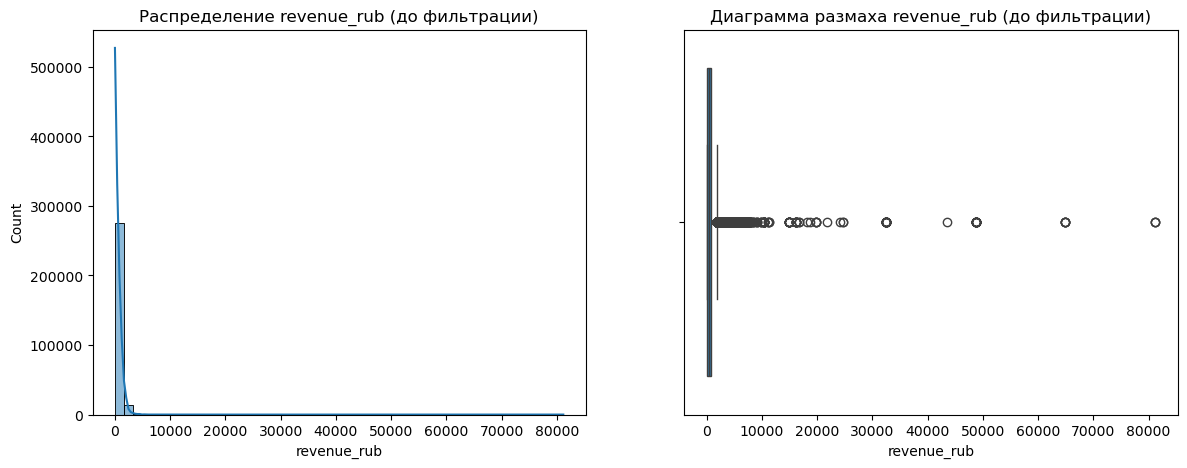


--- Статистика по tickets_count (ДО фильтрации) ---
count    290230.000000
mean          2.755149
std           1.170634
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          57.000000
Name: tickets_count, dtype: float64


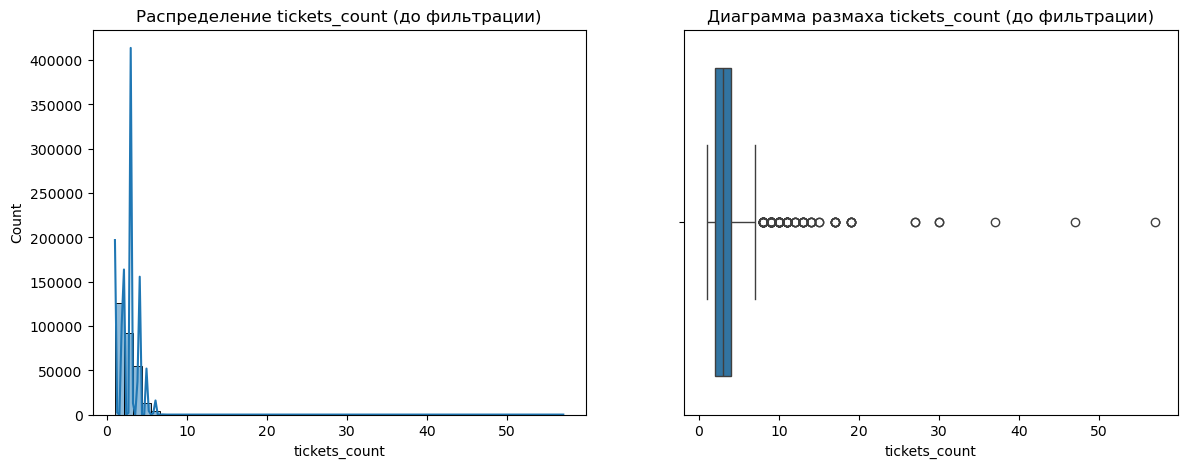

In [33]:
# Проанализируем исходные данные столбцам revenue_rub и tickets_count
cols_to_analyze = ['revenue_rub', 'tickets_count']

for col in cols_to_analyze:
    print(f"\n--- Статистика по {col} (ДО фильтрации) ---")
    print(df_processed[col].describe())
    
    plt.figure(figsize=(14, 5))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(df_processed[col], bins=50, kde=True)
    plt.title(f'Распределение {col} (до фильтрации)')
    
    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=df_processed[col])
    plt.title(f'Диаграмма размаха {col} (до фильтрации)')
    
    plt.show()

**Анализ результатов**

Выручка (revenue_rub):
- Сильная асимметрия: Распределение крайне смещено вправо. Среднее значение (556.3) значительно выше медианы (352.1), что указывает на влияние аномально дорогих заказов.
- Экстремальные выбросы: Максимальная выручка составляет 81 174.5 руб., в то время как 75% всех заказов не превышают 802.25 руб. На диаграмме размаха виден «длинный хвост» одиночных значений, уходящий далеко за пределы типичных трат.
- Вариативность: Высокое стандартное отклонение (875.8) говорит о сильном разбросе данных.

Количество билетов (tickets_count):
- Типичный заказ: В среднем пользователи покупают 2-3 билета (медиана - 3).
- Аномалии: Присутствуют заказы с количеством билетов до 57 штук. Это может указывать на корпоративные закупки или групповые заказы, которые сильно выбиваются из общего поведения обычных пользователей.

Для очистки данных от шума и подготовки их к корректному анализу произведем фильтрацию по 99-му перцентилю столбца revenue_rub.

In [34]:
# Отфильтруем значения по 99 перцентилю
p99_revenue_rub = df_processed['revenue_rub'].quantile(0.99)
print(f"\n99-й перцентиль revenue_rub: {p99_revenue_rub:.2f}")

initial_rows = len(df_processed)
df_processed = df_processed[df_processed['revenue_rub'] <= p99_revenue_rub]
filtered_rows = len(df_processed)

print(f"Количество строк до фильтрации по 99-му перцентилю revenue_rub: {initial_rows}")
print(f"Количество строк после фильтрации по 99-му перцентилю revenue_rub: {filtered_rows}")
print(f"Удалено строк: {initial_rows - filtered_rows} ({((initial_rows - filtered_rows) / initial_rows) * 100:.2f}%)")


99-й перцентиль revenue_rub: 2628.42
Количество строк до фильтрации по 99-му перцентилю revenue_rub: 290230
Количество строк после фильтрации по 99-му перцентилю revenue_rub: 287405
Удалено строк: 2825 (0.97%)


         revenue_rub  tickets_count
count  287405.000000  287405.000000
mean      518.719299       2.741323
std       511.951843       1.163087
min         0.000000       1.000000
25%       112.599998       2.000000
50%       344.829987       3.000000
75%       788.900024       3.000000
max      2628.421631      57.000000


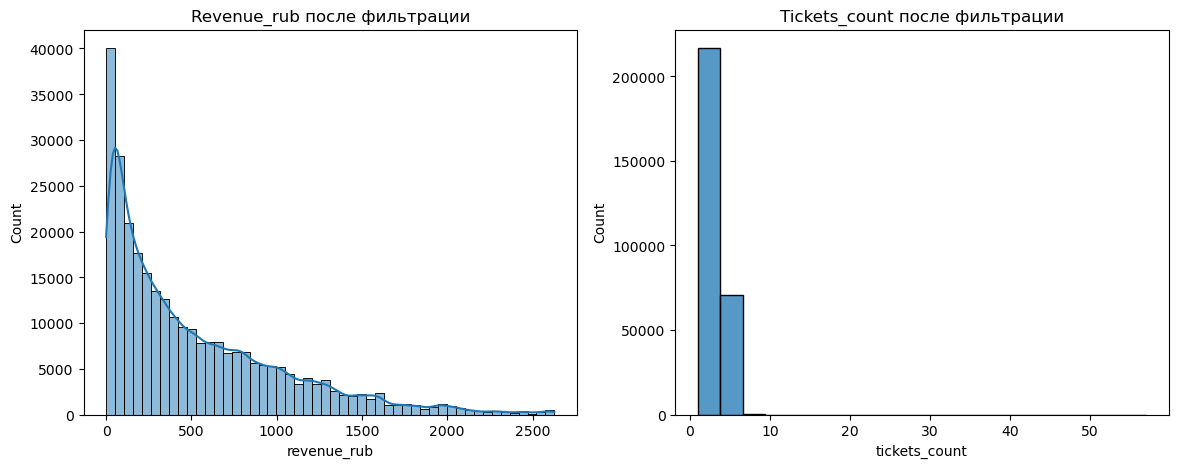

In [35]:
# Проверка распределения ПОСЛЕ фильтрации
print(df_processed[['revenue_rub', 'tickets_count']].describe())

# Визуализация очищенных данных
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_processed['revenue_rub'], bins=50, kde=True)
plt.title('Revenue_rub после фильтрации')

plt.subplot(1, 2, 2)
sns.histplot(df_processed['tickets_count'], bins=20, kde=False)
plt.title('Tickets_count после фильтрации')
plt.show()

**Анализ результатов после фильтрации**

- Стабилизация метрик: Средняя выручка снизилась с 556.3 до 518.7 руб., а стандартное отклонение уменьшилось почти в 1.7 раза (с 875.8 до 511.9). Это делает статистические показатели более устойчивыми и пригодными для дальнейшего анализа.
- Визуальная ясность: На обновленной гистограмме распределения выручки теперь четко видна структура основной массы заказов. График перестал быть «сплюснутым» и стал информативным.
- Влияние на билеты: Среднее количество билетов почти не изменилось, фильтрация по выручке не убрала аномалии в tickets_count (максимум остался 57), однако, среднее количество билетов (2.74) практически совпадает с медианой (3.0). Это означает, что оставшиеся единичные крупные заказы не «перетягивают» на себя статистику и не искажают общую картину.

<div class="alert alert-info"> <b>Комментарии студента:</b> Добавлена статистика по tickets_count, расширены выводы, добавлены обоснования фильтрации только по значению revenue_rub. Переделаны гистограмма и диаграмма размаха, добавлена гистограмма после фильтрации

**Выведем общую информацию о датафрейме после предобработке данных**

In [36]:
# Сбросим индексы для корректного отображения информации
df_processed.reset_index(drop=True, inplace=True)
# Проверим результат
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287405 entries, 0 to 287404
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                287405 non-null  object        
 1   device_type_canonical  287405 non-null  category      
 2   order_id               287405 non-null  int32         
 3   order_dt               287405 non-null  datetime64[ns]
 4   order_ts               287405 non-null  datetime64[ns]
 5   currency_code          287405 non-null  category      
 6   revenue                287405 non-null  float32       
 7   tickets_count          287405 non-null  int8          
 8   days_since_prev        265705 non-null  float32       
 9   event_id               287405 non-null  int32         
 10  event_type_main        287405 non-null  category      
 11  service_name           287405 non-null  category      
 12  region_name            287405 non-null  cate

### Вывод по предобработке данных:

Проведена комплексная предобработка датасета за период с июня по октябрь 2024 года с целью подготовки данных для модели прогнозирования возврата пользователей.

1. Конвертация валют: Все финансовые показатели приведены к российскому рублю по ежедневному курсу. Это позволило корректно рассчитать совокупную выручку и средний чек, исключив искажения из-за колебаний курса KZT.

2. Очистка от аномалий:
- Удалены записи с отрицательной выручкой (0.13%), которые могли быть вызваны техническими ошибками или возвратами, не отражающими покупательскую активность.
- Заказы с "нулевой выручкой" были намеренно оставлены, так как они важны для анализа удержания (промо-акции, пригласительные билеты), которые влияют на возвращаемость.

3.  Фильтрация выбросов по 99-му перцентилю revenue_rub: Применение фильтрации по 99-му перцентилю позволило отсечь экстремальные выбросы (оптовые закупки или технические ошибки), снизив стандартное отклонение в 1.7 раза. Это сделало средние показатели более устойчивыми и репрезентативными для большинства пользователей.

4. Оптимизация: Перевод строковых данных в category и понижение разрядности чисел позволили сократить объем памяти в 2 раза, что ускоряет работу с профилями пользователей.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
* В целом с задачей справились, предобработку провели!
    
    
* Хорошо, что сопровождаешь графики заголовком и всеми необходимыми подписями - сразу понятно, что изображено на нем и как его читать!

</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

    
* Сейчас ты фиксируешь общие выводы только в конце раздела. Чтобы в работе был понятный сторителлинг, стоит также фиксировать промежуточные свои наблюдения для каждого из шагов: почему мы ничего не стали делать с пропусками и перешли к следующему шагу? Как приняли решение скорректировать тип у тех или иных столбцов? Действительно ли наши категориальные признаки в порядке и не требуют нормализации? Действительно ли в числовых признаках есть выбросы, какова их предполагаемая природа возникновения? Почему мы решили отбросить выбросы в выручке? Почему решили не отбрасывать выбросы в количестве билетов?
    
   

# 4. Создание профиля пользователя

In [37]:
# Обязательная сортировка перед агрегацией
df_processed = df_processed.sort_values(by=['user_id', 'order_ts'])

# Создаем профиль пользователя
user_profiles = df_processed.groupby('user_id').agg(
    # Даты первого и последнего заказов
    first_order_dt=('order_ts', 'min'),
    last_order_dt=('order_ts', 'max'),
    
    # Характеристики первого заказа (берем первое встретившееся значение после сортировки)
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_partner=('service_name', 'first'),
    first_genre=('event_type_main', 'first'),
    
    # Количественные показатели
    total_orders=('order_id', 'count'),
    avg_revenue_rub=('revenue_rub', 'mean'),
    avg_tickets_count=('tickets_count', 'mean'),
    
    # Среднее время между заказами (используем существующий days_since_prev)
    avg_time_between_orders=('days_since_prev', 'mean')
).reset_index()

# Проверка результата
print(user_profiles.head())
print(user_profiles.info())

           user_id      first_order_dt       last_order_dt first_device  \
0  0002849b70a3ce2 2024-08-20 16:08:03 2024-08-20 16:08:03       mobile   
1  0005ca5e93f2cf4 2024-07-23 18:36:24 2024-10-06 13:56:02       mobile   
2  000898990054619 2024-07-13 19:40:48 2024-10-23 15:12:00       mobile   
3  00096d1f542ab2b 2024-08-15 16:48:48 2024-08-15 16:48:48      desktop   
4  000a55a418c128c 2024-09-29 19:39:12 2024-10-15 10:29:04       mobile   

           first_region  first_partner first_genre  total_orders  \
0    Каменевский регион   Край билетов       театр             1   
1    Каменевский регион      Мой билет    выставки             2   
2  Североярская область    Лови билет!      другое             3   
3    Каменевский регион   Край билетов       театр             1   
4      Поленовский край  Лучшие билеты       театр             2   

   avg_revenue_rub  avg_tickets_count  avg_time_between_orders  
0      1521.939941           4.000000                      NaN  
1       77

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Правильно, что перед агрегацией сортируешь по пользователю и дате, чтобы первый заказ был первым

### Добавим два бинарных признака
- is_two — совершил ли пользователь 2 и более заказа;
- is_five — совершил ли пользователь 5 и более заказов.

In [38]:
# is_two
user_profiles['is_two'] = (user_profiles['total_orders'] >= 2).astype(int)

# is_five
user_profiles['is_five'] = (user_profiles['total_orders'] >= 5).astype(int)

# Проверка результата:
user_profiles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21838 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21838 non-null  object        
 1   first_order_dt           21838 non-null  datetime64[ns]
 2   last_order_dt            21838 non-null  datetime64[ns]
 3   first_device             21838 non-null  category      
 4   first_region             21838 non-null  category      
 5   first_partner            21838 non-null  category      
 6   first_genre              21838 non-null  category      
 7   total_orders             21838 non-null  int64         
 8   avg_revenue_rub          21838 non-null  float32       
 9   avg_tickets_count        21838 non-null  float64       
 10  avg_time_between_orders  13504 non-null  float32       
 11  is_two                   21838 non-null  int64         
 12  is_five                  21838 n

### Преобразуем типы данных для оптимизации памяти и улучшения производительности.

In [39]:
# Определяем переменные для столбцов, которые подлежат преобразованию
int_columns = ['total_orders', 'is_two', 'is_five']
float_columns = ['avg_revenue_rub', 'avg_tickets_count', 'avg_time_between_orders']

# Преобразуем целочисленные данные
for col in int_columns:
    if col in user_profiles.columns:
        user_profiles[col] = pd.to_numeric(user_profiles[col], downcast='integer')

# Преобразуем столбцы с плавающей запятой
for col in float_columns:
    if col in user_profiles.columns:
        user_profiles[col] = pd.to_numeric(user_profiles[col], downcast='float')

# Перепроверим после преобразований
user_profiles.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21838 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   user_id                  21838 non-null  object        
 1   first_order_dt           21838 non-null  datetime64[ns]
 2   last_order_dt            21838 non-null  datetime64[ns]
 3   first_device             21838 non-null  category      
 4   first_region             21838 non-null  category      
 5   first_partner            21838 non-null  category      
 6   first_genre              21838 non-null  category      
 7   total_orders             21838 non-null  int16         
 8   avg_revenue_rub          21838 non-null  float32       
 9   avg_tickets_count        21838 non-null  float32       
 10  avg_time_between_orders  13504 non-null  float32       
 11  is_two                   21838 non-null  int8          
 12  is_five                  21838 n

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__

    
Вручную подставляешь данные, используй, пожалуйста, переменные

<div class="alert alert-info"> <b>Комментарии студента:</b>  Исправлено

### Используя данные о профилях пользователей, рассчитаем:
- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

In [40]:
# Общее число пользователей в выборке
total_users = user_profiles.shape[0]

# Средняя выручка с одного заказа
total_revenue_all_users = (user_profiles['avg_revenue_rub'] * user_profiles['total_orders']).sum()
total_orders_all_users = user_profiles['total_orders'].sum()
average_revenue_per_order = total_revenue_all_users / total_orders_all_users

# Доля пользователей, совершивших 2 и более заказа
share_two_or_more_orders = user_profiles['is_two'].mean()

# Доля пользователей, совершивших 5 и более заказов
share_five_or_more_orders = user_profiles['is_five'].mean()

print(f"1. Общее число пользователей в выборке: {total_users}")
print(f"2. Средняя выручка с одного заказа: {average_revenue_per_order:.2f} RUB")
print(f"3. Доля пользователей, совершивших 2 и более заказа: {share_two_or_more_orders:.2%}")
print(f"4. Доля пользователей, совершивших 5 и более заказов: {share_five_or_more_orders:.2%}")

1. Общее число пользователей в выборке: 21838
2. Средняя выручка с одного заказа: 518.72 RUB
3. Доля пользователей, совершивших 2 и более заказа: 61.70%
4. Доля пользователей, совершивших 5 и более заказов: 29.00%


### Изучим статистические показатели:

In [41]:
# По общему числу заказов (total_orders)
print("\n1. Статистика по 'total_orders' (общее число заказов на пользователя):")
total_orders_stats = user_profiles['total_orders'].describe()
print(total_orders_stats)
print(f"Асимметрия (Skewness): {user_profiles['total_orders'].skew():.2f}")
print(f"Эксцесс (Kurtosis): {user_profiles['total_orders'].kurt():.2f}")


1. Статистика по 'total_orders' (общее число заказов на пользователя):
count    21838.000000
mean        13.160775
std        121.577370
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max      10168.000000
Name: total_orders, dtype: float64
Асимметрия (Skewness): 41.49
Эксцесс (Kurtosis): 2623.48


In [42]:
# По среднему числу билетов в заказе (avg_tickets_count)
print("\n2. Статистика по 'avg_tickets_count' (среднее число билетов в заказе на пользователя):")
avg_tickets_stats = user_profiles['avg_tickets_count'].describe()
print(avg_tickets_stats)
print(f"Асимметрия (Skewness): {user_profiles['avg_tickets_count'].skew():.2f}")
print(f"Эксцесс (Kurtosis): {user_profiles['avg_tickets_count'].kurt():.2f}")


2. Статистика по 'avg_tickets_count' (среднее число билетов в заказе на пользователя):
count    21838.000000
mean         2.744062
std          0.913077
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets_count, dtype: float64
Асимметрия (Skewness): 0.56
Эксцесс (Kurtosis): 1.59


In [43]:
# По среднему количеству дней между покупками (avg_time_between_orders)
print("\n3. Статистика по 'avg_time_between_orders' (среднее количество дней между покупками):")
# Важно: этот столбец содержит NaN для пользователей с одним заказом.
# describe() автоматически игнорирует NaN, поэтому 'count' будет меньше общего числа пользователей.
avg_time_stats = user_profiles['avg_time_between_orders'].describe()
print(avg_time_stats)
print(f"Асимметрия (Skewness): {user_profiles['avg_time_between_orders'].skew():.2f}")
print(f"Эксцесс (Kurtosis): {user_profiles['avg_time_between_orders'].kurt():.2f}")


3. Статистика по 'avg_time_between_orders' (среднее количество дней между покупками):
count    13504.000000
mean        15.864347
std         22.330114
min          0.000000
25%          1.000000
50%          8.000000
75%         20.500000
max        148.000000
Name: avg_time_between_orders, dtype: float64
Асимметрия (Skewness): 2.57
Эксцесс (Kurtosis): 7.88


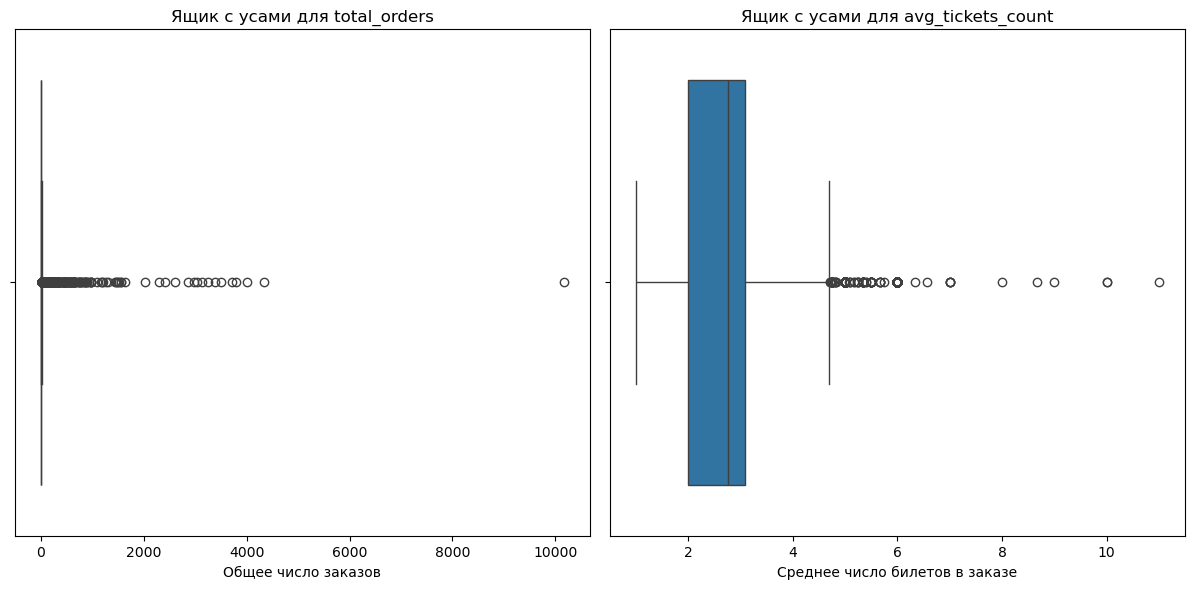

In [44]:
# Настройка графиков
plt.figure(figsize=(18, 6))

# Ящик с усами для total_orders
plt.subplot(1, 3, 1)
sns.boxplot(x=user_profiles['total_orders'])
plt.title("Ящик с усами для total_orders")
plt.xlabel("Общее число заказов")

# Ящик с усами для avg_tickets_count
plt.subplot(1, 3, 2)
sns.boxplot(x=user_profiles['avg_tickets_count'])
plt.title("Ящик с усами для avg_tickets_count")
plt.xlabel("Среднее число билетов в заказе")

# Отображение графиков
plt.tight_layout()
plt.show()

**Оценка объема данных:**

- Общее число пользователей (21838): Это хороший объем для проведения статистического анализа. Достаточно, чтобы выявлять тенденции и паттерны.
- Высокая доля повторных заказов:
  - 61.7% пользователей совершили 2 и более заказа.
  - 29% пользователей совершили 5 и более заказов.
  Это указывает на очень хорошую лояльность или высокую вовлеченность пользователей.
- Средняя выручка с одного заказа (518.72 RUB).

**Анализ аномалий и статистических показателей:**

- Показатель total_orders (Общее число заказов)
    - Аномалия: Максимальное значение - 10 168 заказов. При этом медиана - всего 2 заказа, а 75-й перцентиль - 5 заказов.
Это критическая аномалия. Среднее значение (13.16) в 6 раз больше медианы только из-за сверхтяжелого "хвоста". Коэффициент асимметрии (41.49) и эксцесс (2623.48) подтверждают, что распределение максимально далеко от нормального.

- Показатель avg_tickets_count (Среднее число билетов)
   - Аномалия: Максимальное значение - 11.
Это не аномалия. 11 билетов в заказе - это реальная ситуация (большая компания, школьная группа и т.д.). Коэффициент асимметрии (0.56) низкий, распределение выглядит здоровым.

- Показатель avg_time_between_orders (Время между покупками)
   - Статистика: В расчете участвовало 13 504 человек
   - Аномалия: Минимальное значение 0 дней (пользователь делает несколько заказов в один день) и максимальное 148 дней. Среднее (15.86) и медиана (8.0).
Данные выглядят логично. Коэффициент асимметрии (2.57) умеренный.



### Проверим 95-й и 99-й процентиль столбца total_orders

In [45]:
# Вычисление 95-го и 99-го процентилей
percentile_95 = user_profiles['total_orders'].quantile(0.95)
percentile_99 = user_profiles['total_orders'].quantile(0.99)

print("95-й процентиль total_orders:", percentile_95)
print("99-й процентиль total_orders:", percentile_99)


95-й процентиль total_orders: 31.0
99-й процентиль total_orders: 152.0


### Отфильтруем данные по 99-ому перцентилю

In [46]:
# Отфильтруем значения по 99 перцентилю
initial_rows = len(user_profiles)
user_profiles = user_profiles[user_profiles['total_orders'] <= percentile_99]
filtered_rows = len(user_profiles)

print(f"Количество строк до фильтрации по 99-му перцентилю total_orders: {initial_rows}")
print(f"Количество строк после фильтрации по 99-му перцентилю total_orders: {filtered_rows}")
print(f"Удалено строк: {initial_rows - filtered_rows} ({((initial_rows - filtered_rows) / initial_rows) * 100:.2f}%)")

Количество строк до фильтрации по 99-му перцентилю total_orders: 21838
Количество строк после фильтрации по 99-му перцентилю total_orders: 21622
Удалено строк: 216 (0.99%)


In [47]:
print("Статистика по 'total_orders' (после фильтрации):")
total_orders_stats = user_profiles['total_orders'].describe()
print(total_orders_stats)
print(f"Асимметрия (Skewness): {user_profiles['total_orders'].skew():.2f}")
print(f"Эксцесс (Kurtosis): {user_profiles['total_orders'].kurt():.2f}")

Статистика по 'total_orders' (после фильтрации):
count    21622.000000
mean         6.496624
std         14.310784
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        152.000000
Name: total_orders, dtype: float64
Асимметрия (Skewness): 5.42
Эксцесс (Kurtosis): 36.09


**Что было сделано:**

1. Идентификация аномалии: Изначально мы обнаружили, что в данных о total_orders присутствует экстремально большое значение (10 168 заказов), которое находится далеко за пределами распределения основной массы пользователей. Это было очевидно по следующим признакам:
  - Максимальное значение (10 168) было в сотни раз больше медианы (2).
  - Очень высокое стандартное отклонение (121.58), многократно превышающее среднее (13.16).
  - Экстремально высокие показатели асимметрии (41.49) и эксцесса (2623.48), указывающие на сильное искажение распределения выбросом.
  - Визуально на графике Boxplot (ящик с усами) большинство данных сосредоточено у нуля, а выброс представлял собой одну далекую точку.

2. Принятие решения о фильтрации: Было принято решение отфильтровать данные для того, чтобы получить более репрезентативные статистические показатели, которые отражают поведение большинства пользователей, а не искажены отдельными экстремальными значениями.

3. Выбор порога фильтрации: Были рассмотрены два варианта:
  - 95-й перцентиль (31 заказ): Этот порог отсекает 5% самых активных пользователей, что может привести к потере данных о клиентах, которые приносят значительную часть дохода.
  - 99-й перцентиль (152 заказа): Этот порог отсекает только 1% самых активных пользователей. Это позволило избавиться от явного технического мусора или единичных случаев оптовых закупок/ботов, сохраняя при этом ценный сегмент пользователей с высоким, но реальным числом заказов.

4. Окончательный выбор фильтрации: Фильтрация была проведена по 99-му перцентилю. Это было обосновано тем, что:
  - Минимальная потеря данных: Удаляется лишь 1% пользователей, что позволяет сохранить большую часть выборки.
  - Устранение явных искажений: Устраняется самое экстремальное значение (10 168), которое искажало среднее и другие статистические показатели.
  - Сохранение «Power Users»: Сегмент пользователей с количеством заказов от 32 до 152 (95-й и 99-й перцентили) был оставлен, поскольку это могут быть реальные, очень лояльные клиенты, которые важны для бизнеса.

**Результат фильтрации:**

- Количество пользователей: Сократилось с 21 838 до 21 622 (удалено 216 пользователей, 0.99%).
- Среднее число заказов (total_orders): Резко снизилось с 13.16 до 6.50.
- Стандартное отклонение: Значительно уменьшилось со 121.58 до 14.31, указывая на гораздо меньший разброс данных.
- Максимальное значение: Уменьшилось с 10 168 до 152.
- Асимметрия и эксцесс: Значительно снизились (с 41.49 до 5.42 и с 2623.48 до 36.09 соответственно), что делает распределение более адекватным для статистического анализа.

Вывод: Фильтрация по 99-му перцентилю позволила получить более реалистичные и репрезентативные статистические показатели по total_orders, которые лучше отражают поведение основной массы пользователей, сохранив при этом ценную информацию о самых лояльных клиентах.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

    
Здесь  все супер, выполнены все необходимые шаги! 
    
  

# 5. Исследовательский анализ данных

##  Изучим распределение пользователей по признакам.

In [48]:
# Список признаков для анализа
features = ['first_genre', 'first_device', 'first_region', 'first_partner']

# Словарь для хранения результатов
results = {}

for feature in features:
    # Группируем, считаем количество пользователей
    dist = user_profiles.groupby(feature, observed=False).agg(
        user_count=('user_id', 'count')
    ).reset_index()
    
    # Считаем процент пользователей в каждом сегменте
    total_users = user_profiles['user_id'].nunique()  # Общее количество уникальных пользователей
    dist['proportion'] = (dist['user_count'] / total_users * 100).round(2)

    # Сохраняем в словарь
    results[feature] = dist
   
    # Сортируем по убыванию для наглядности
    dist = dist.sort_values(by='user_count', ascending=False)

    # Выводим результаты
    print(f'\nРаспределение пользователей по признаку: {feature}')
    print(dist)


Распределение пользователей по признаку: first_genre
  first_genre  user_count  proportion
2    концерты        9564       44.23
1      другое        5401       24.98
5       театр        4245       19.63
4     стендап        1110        5.13
3       спорт         794        3.67
0    выставки         413        1.91
6        ёлки          95        0.44

Распределение пользователей по признаку: first_device
  first_device  user_count  proportion
1       mobile       17906       82.81
0      desktop        3716       17.19

Распределение пользователей по признаку: first_region
                first_region  user_count  proportion
23        Каменевский регион        7086       32.77
60      Североярская область        3768       17.43
77       Широковская область        1223        5.66
45          Озернинский край         675        3.12
41      Малиновоярский округ         526        2.43
..                       ...         ...         ...
17            Залесский край           2    

<div class="alert alert-info"> <b>Комментарии студента:</b>  Добавляем визуализацию

**Визуализируем полученые результаты**

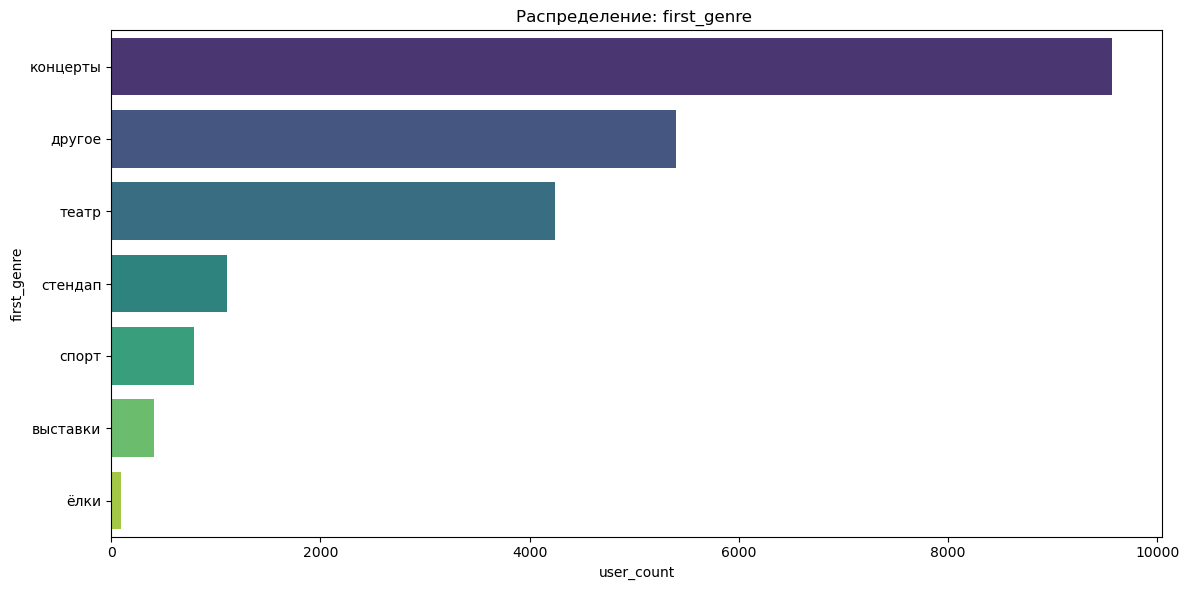

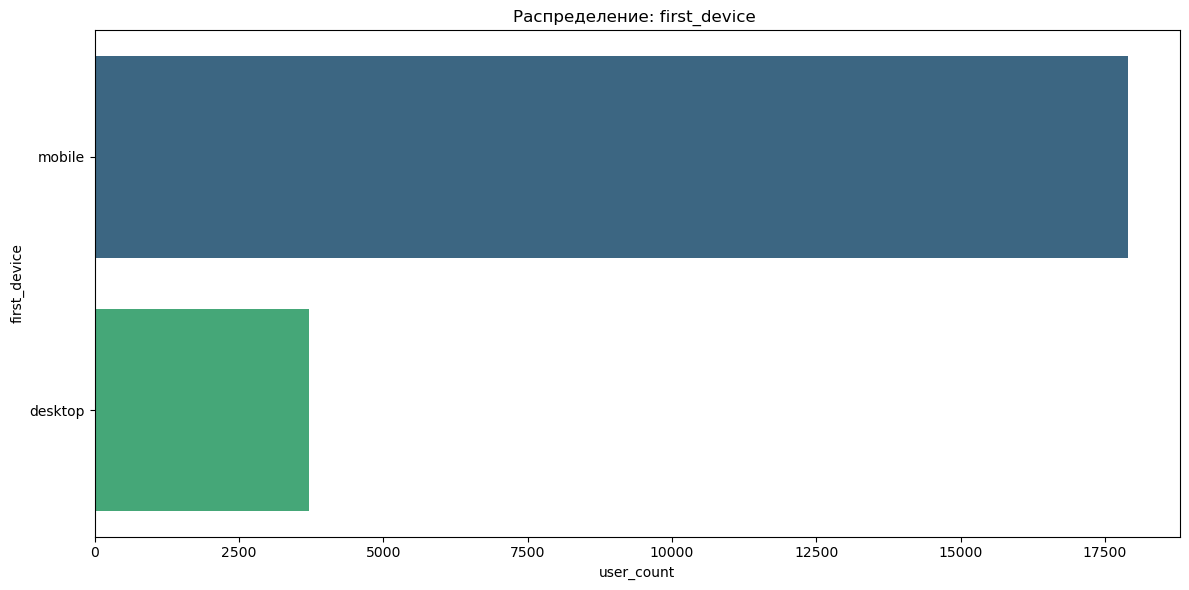

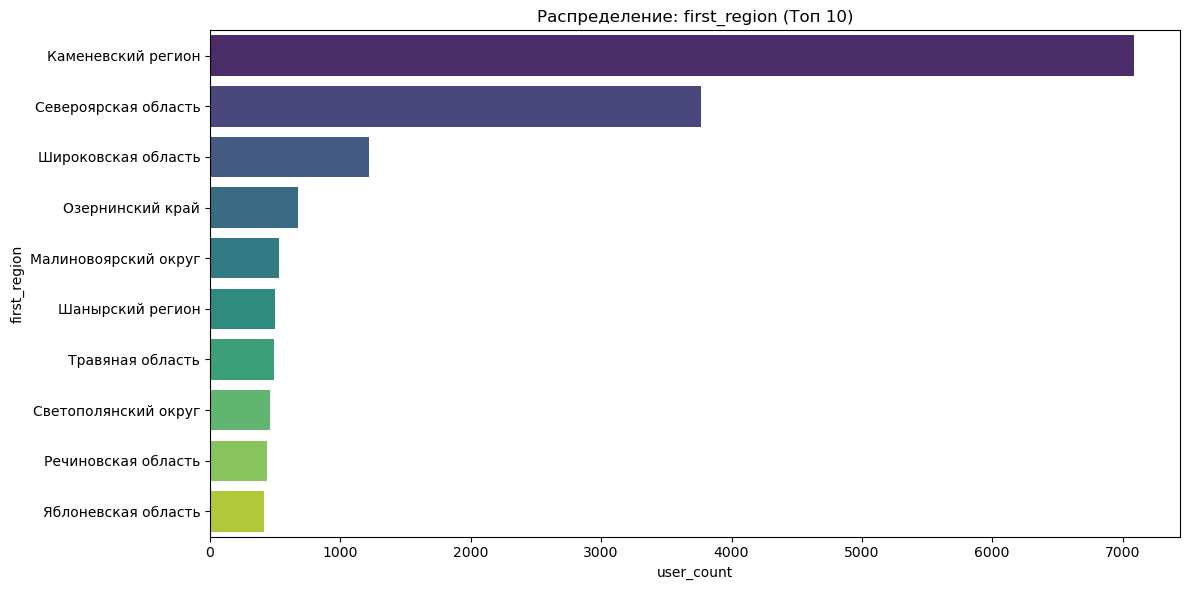

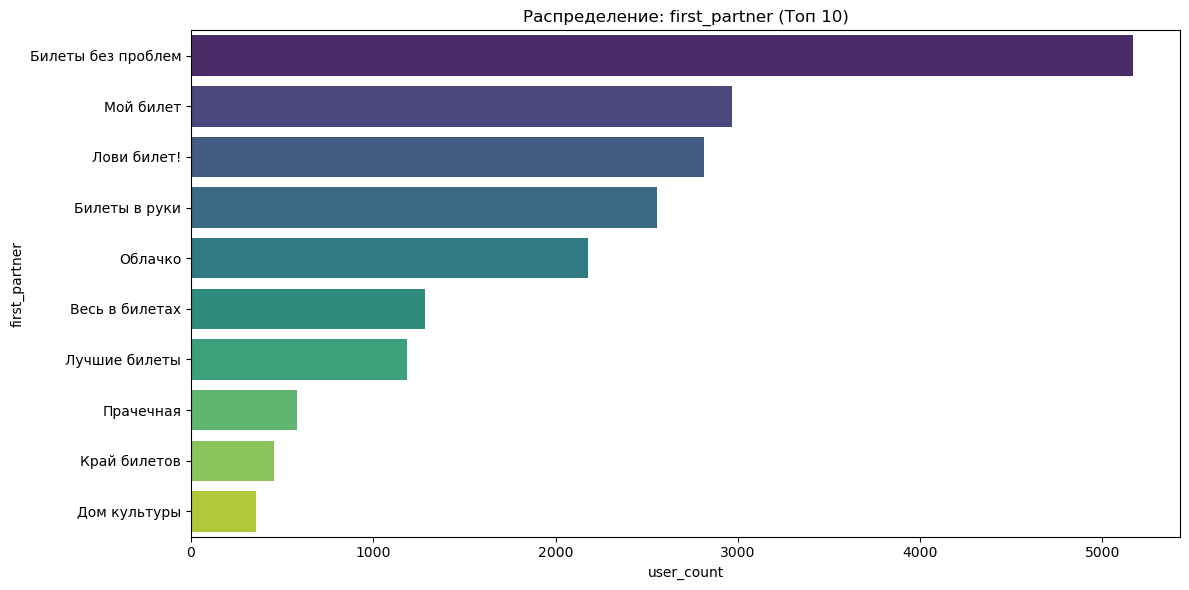

In [49]:
# Функция для визуализации распределения пользователей по признаку
def plot_user_distribution(dist, feature, top_n=None):
    # Сортируем по убыванию
    data_to_plot = dist.sort_values(by='user_count', ascending=False).copy()
    
    # Если строк больше 10, функция оставит только топ-10
    if len(data_to_plot) > 10:
        data_to_plot = data_to_plot.head(10)
        title_suffix = '(Топ 10)'
    else:
        title_suffix = ''
    # Преобразуем в строку — это убирает пустые места на графике
    data_to_plot[feature] = data_to_plot[feature].astype(str)
    
    # Строим график
    plt.figure(figsize=(12, 6))
    sns.barplot(data=data_to_plot, x='user_count', y=feature, palette='viridis', hue=feature, legend=False)
    
    plt.title(f'Распределение: {feature} {title_suffix}')
    plt.tight_layout()
    plt.show()

# Запускаем цикл по всем признакам
for feature in features:
    plot_user_distribution(results[feature], feature)

<div class="alert alert-info"> <b>Комментарии студента:</b>  Исправлены комментарии

**Анализ результатов:**

1. Доминирующие сегменты

Анализ показывает ярко выраженную концентрацию интересов пользователей. Основным драйвером привлечения являются концерты, а основным инструментом доступа - мобильные устройства. Это характерно для современной B2C-платформы: покупка билетов на массовые мероприятия (концерты) часто бывает импульсивной и совершается «на ходу» через смартфон. Концерты обеспечивают самый широкий охват аудитории по сравнению с узконишевыми выставками или сезонными «ёлками». Доля мобильных устройств составляет подавляющие 82.8%, а концерты выбрали почти 44.2% новых пользователей.

2. Географическая концентрация

Рынок сбыта сильно централизован. Всего два региона обеспечивают половину всего притока новых клиентов. Вероятно, в Каменевском регионе и Североярской области сосредоточены крупнейшие концертные площадки страны или именно там компания проводила наиболее активные маркетинговые кампании. Огромный «хвост» из 80+ регионов с минимальными продажами говорит о том, что экспансия в регионы находится на начальном этапе. На Каменевский регион (32.8%) и Североярскую область (17.4%) суммарно приходится более 50% всех регистраций. Остальные 79 регионов распределены крайне тонким слоем (менее 5% на каждый).

3. Партнеры и конкуренция

Распределение по билетным операторам выглядит более сбалансированным, чем по регионам, однако лидер всё же очевиден. Наличие одного крупного лидера («Билеты без проблем») при наличии десятка средних игроков указывает на умеренно конкурентный рынок. Большое количество мелких партнеров с долей менее 1% свидетельствует о высокой фрагментации - сервис сотрудничает с множеством локальных площадок, но основные продажи идут через агрегаторы-гиганты. Лидер рынка занимает 23.9%, в то время как ближайшие преследователи («Мой билет» и «Лови билет!») удерживают по 13%.

4. Редкие и специфичные категории

Такие категории, как «ёлки» (0.4%) или «выставки» (1.9%), показывают минимальную эффективность в привлечении новых пользователей. «Ёлки» - это сезонный продукт с очень коротким окном продаж. Выставки и спорт, вероятно, требуют иного подхода к маркетингу или имеют более лояльную, но узкую аудиторию, которая реже становится «новым» пользователем в общей массе.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

По результатам всё верно
    
    
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

    
* Визуализировать полученные данные,     
    
* По выводам хорошо бы показать общую картину: как распределяются пользователи по сегментам, какие группы преобладают, какие встречаются реже и почему так может быть. А уже после этого привести конкретные значения - как подтверждение своих наблюдений.  

## Проанализируем возвраты пользователей. Для каждого сегмента вычислим долю пользователей, совершивших два и более заказа.

In [50]:
# Список признаков для анализа
features = ['first_genre', 'first_device', 'first_region', 'first_partner']

# Словарь для хранения итогов
results = {}

print("--- Расчет долей возвратов для каждого сегмента ---")
for feature in features:
    # Группируем и считаем количество пользователей с повторными заказами
    dist = user_profiles.groupby(feature, observed=False).agg(
        user_count=('user_id', 'count'),
        repeat_count=('is_two', 'sum')  # Считаем количество пользователей с 2 и более заказами
    ).reset_index()

    # Вычисляем долю пользователей с повторными заказами
    dist['repeat_proportion'] = (dist['repeat_count'] / dist['user_count']*100).round(2)

    # Сортируем по доле возвратов для лучшей читаемости в таблицах и на графиках
    dist = dist.sort_values(by='repeat_proportion', ascending=False)

    # Сохраняем в результирующий словарь для дальнейшего анализа
    results[feature] = dist
    print(f"\nРезультаты для сегмента '{feature}':")
    print(dist.to_string(index=False)) # Используем to_string для полного вывода без индекса
    print("-" * 50)

# Среднее по всем пользователям
overall_repeat_rate = user_profiles['is_two'].mean()
print(f"\nОбщая доля пользователей, совершивших 2 и более заказа (возвраты): {overall_repeat_rate:.2%}\n")

--- Расчет долей возвратов для каждого сегмента ---

Результаты для сегмента 'first_genre':
first_genre  user_count  repeat_count  repeat_proportion
   выставки         413           265              64.16
      театр        4245          2693              63.44
   концерты        9564          5912              61.82
    стендап        1110           676              60.90
     другое        5401          3217              59.56
      спорт         794           443              55.79
       ёлки          95            53              55.79
--------------------------------------------------

Результаты для сегмента 'first_device':
first_device  user_count  repeat_count  repeat_proportion
     desktop        3716          2372              63.83
      mobile       17906         10887              60.80
--------------------------------------------------

Результаты для сегмента 'first_region':
             first_region  user_count  repeat_count  repeat_proportion
        Верхозёрский кр

**Визуализируем результат**

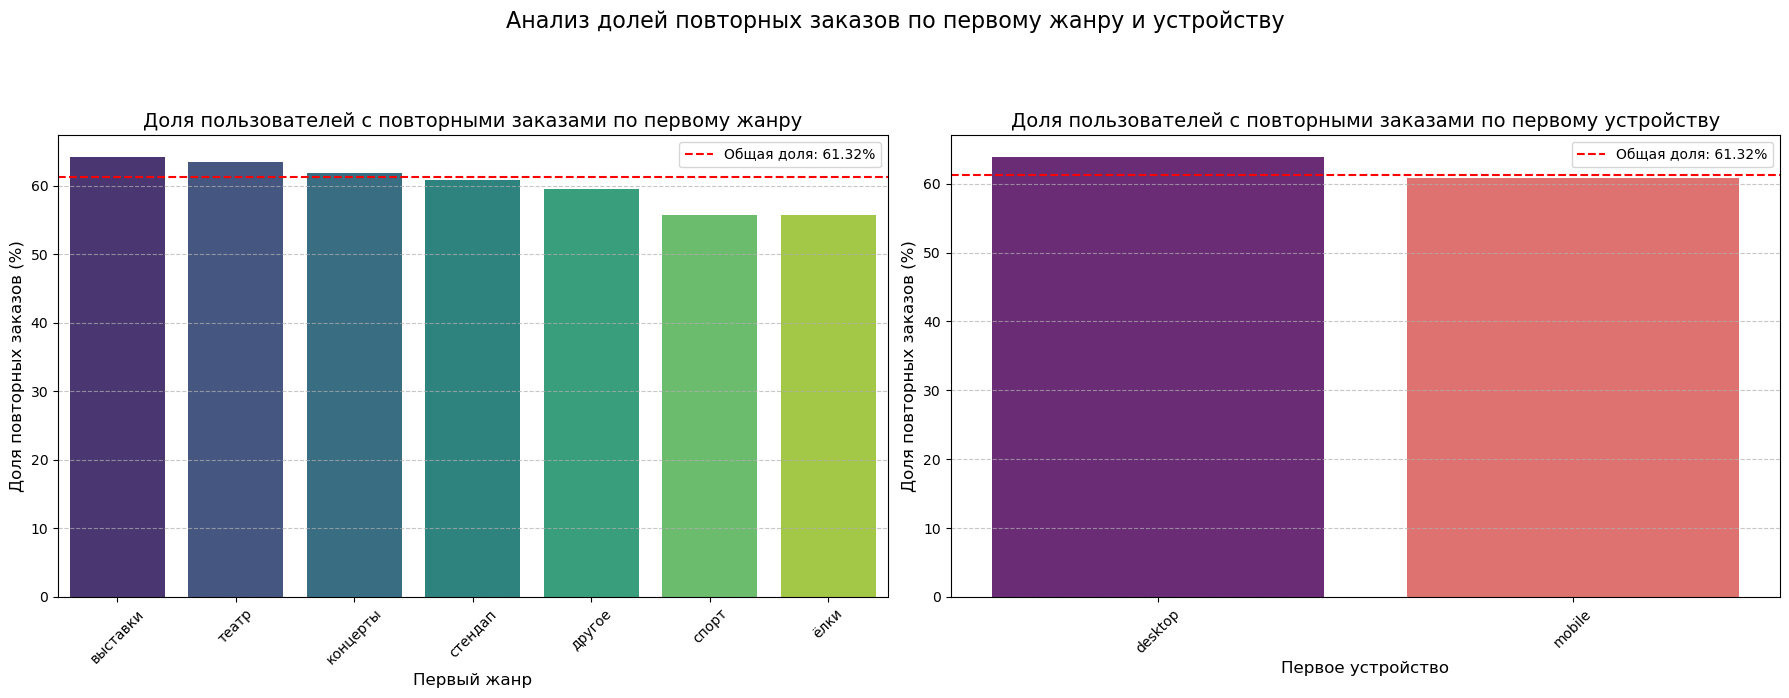

In [51]:
# Визуализация для сегментов first_genre и first_device

# Создаем одну фигуру с двумя подграфиками (1 строка, 2 столбца)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # Увеличиваем ширину для двух графиков

# --- График для first_genre ---
genre_data = results['first_genre']
# Переводим в строку и сортируем
genre_data['first_genre'] = genre_data['first_genre'].astype(str)
genre_data_sorted = genre_data.sort_values(by='repeat_proportion', ascending=False)

# Строим график 
barplot_genre = sns.barplot(
    x='first_genre', 
    y='repeat_proportion', 
    data=genre_data_sorted, 
    palette='viridis', 
    ax=axes[0],
    order=genre_data_sorted['first_genre'], # Явно задаем порядок
    hue='first_genre',
    legend=False
)

# Добавляем заголовок и подписи для первого подграфика
axes[0].set_title('Доля пользователей с повторными заказами по первому жанру', fontsize=14)
axes[0].set_xlabel('Первый жанр', fontsize=12)
axes[0].set_ylabel('Доля повторных заказов (%)', fontsize=12)

# Добавляем горизонтальную линию общей доли
axes[0].axhline(y=overall_repeat_rate * 100, color='red', linestyle='--', label=f'Общая доля: {overall_repeat_rate:.2%}')
axes[0].legend()

axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# --- График для first_device ---
device_data = results['first_device']
# Сортируем данные по доле возвратов для более информативного графика
device_data_sorted = device_data.sort_values(by='repeat_proportion', ascending=False)
barplot_device = sns.barplot(
    x='first_device', 
    y='repeat_proportion', 
    data=device_data_sorted, 
    palette='magma', 
    ax=axes[1],
    order=device_data_sorted['first_device'], # Явно задаем порядок
    hue='first_device',
    legend=False
)

# Добавляем заголовок и подписи для второго подграфика
axes[1].set_title('Доля пользователей с повторными заказами по первому устройству', fontsize=14)
axes[1].set_xlabel('Первое устройство', fontsize=12)
axes[1].set_ylabel('Доля повторных заказов (%)', fontsize=12)

# Добавляем горизонтальную линию общей доли
axes[1].axhline(y=overall_repeat_rate * 100, color='red', linestyle='--', label=f'Общая доля: {overall_repeat_rate:.2%}')
axes[1].legend()
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Общий заголовок для всей фигуры
plt.suptitle('Анализ долей повторных заказов по первому жанру и устройству', fontsize=16, y=1.02)

# Оптимизируем отступы, чтобы все элементы поместились, учитывая suptitle
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Показываем графики
plt.show()

C:\Users\DiFF1\AppData\Local\Temp\ipykernel_24796\2660468374.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


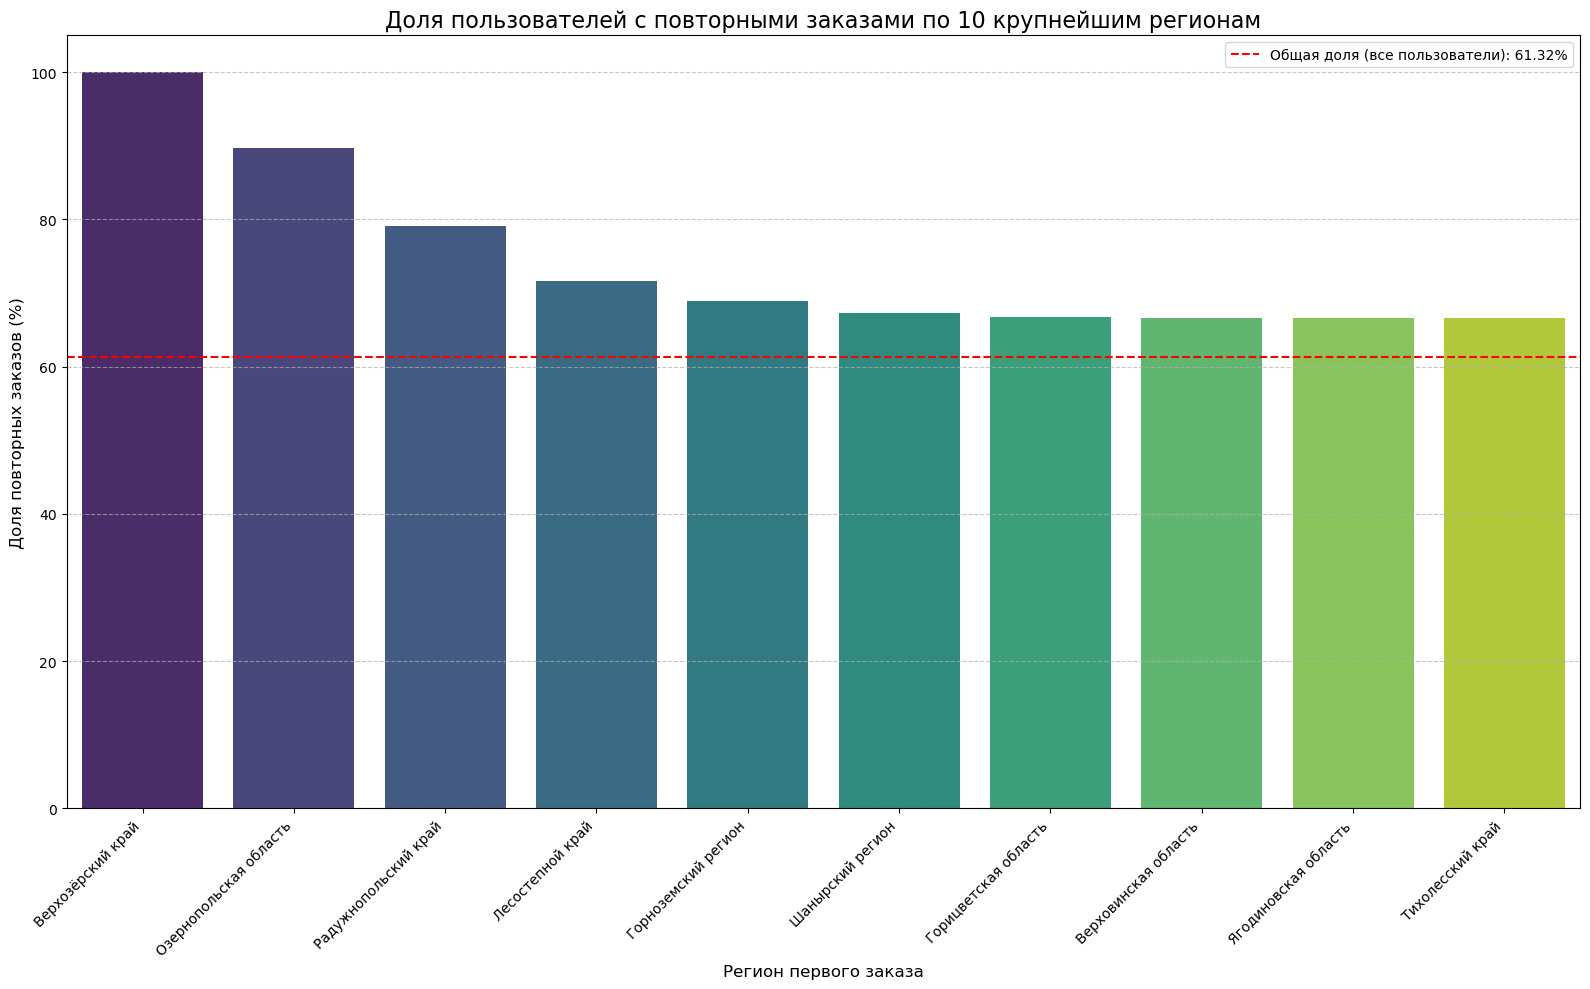

In [52]:
# Визуализация для сегмента first_region

# Получаем данные для региона
region_data = results['first_region']
# Сортируем по repeat_proportion и выбираем топ-10
top_10_regions = region_data.sort_values(by='repeat_proportion', ascending=False).head(10)

# Настраиваем график
plt.figure(figsize=(16, 10))  # Увеличиваем размеры для лучшей читаемости
barplot = sns.barplot(
    x='first_region',
    y='repeat_proportion',
    data=top_10_regions,
    palette='viridis',
    order=top_10_regions['first_region'].tolist()  # Явно указываем порядок и список категорий
)

# Добавляем заголовок и подписи осей
plt.title('Доля пользователей с повторными заказами по 10 крупнейшим регионам', fontsize=16)
plt.xlabel('Регион первого заказа', fontsize=12)
plt.ylabel('Доля повторных заказов (%)', fontsize=12)

# Добавляем горизонтальную линию, показывающую общую долю возвратов
# Умножаем overall_repeat_rate на 100, чтобы он был в той же шкале, что и repeat_proportion
plt.axhline(y=overall_repeat_rate * 100, color='red', linestyle='--', label=f'Общая доля (все пользователи): {overall_repeat_rate:.2%}')
plt.legend()


# Улучшаем читаемость меток по оси X
plt.xticks(rotation=45, ha='right') # Поворачиваем метки, чтобы они не накладывались

# Добавляем сетку для лучшей ориентации
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Оптимизируем отступы, чтобы все элементы поместились
plt.tight_layout()

# Показываем график
plt.show()

C:\Users\DiFF1\AppData\Local\Temp\ipykernel_24796\457255264.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


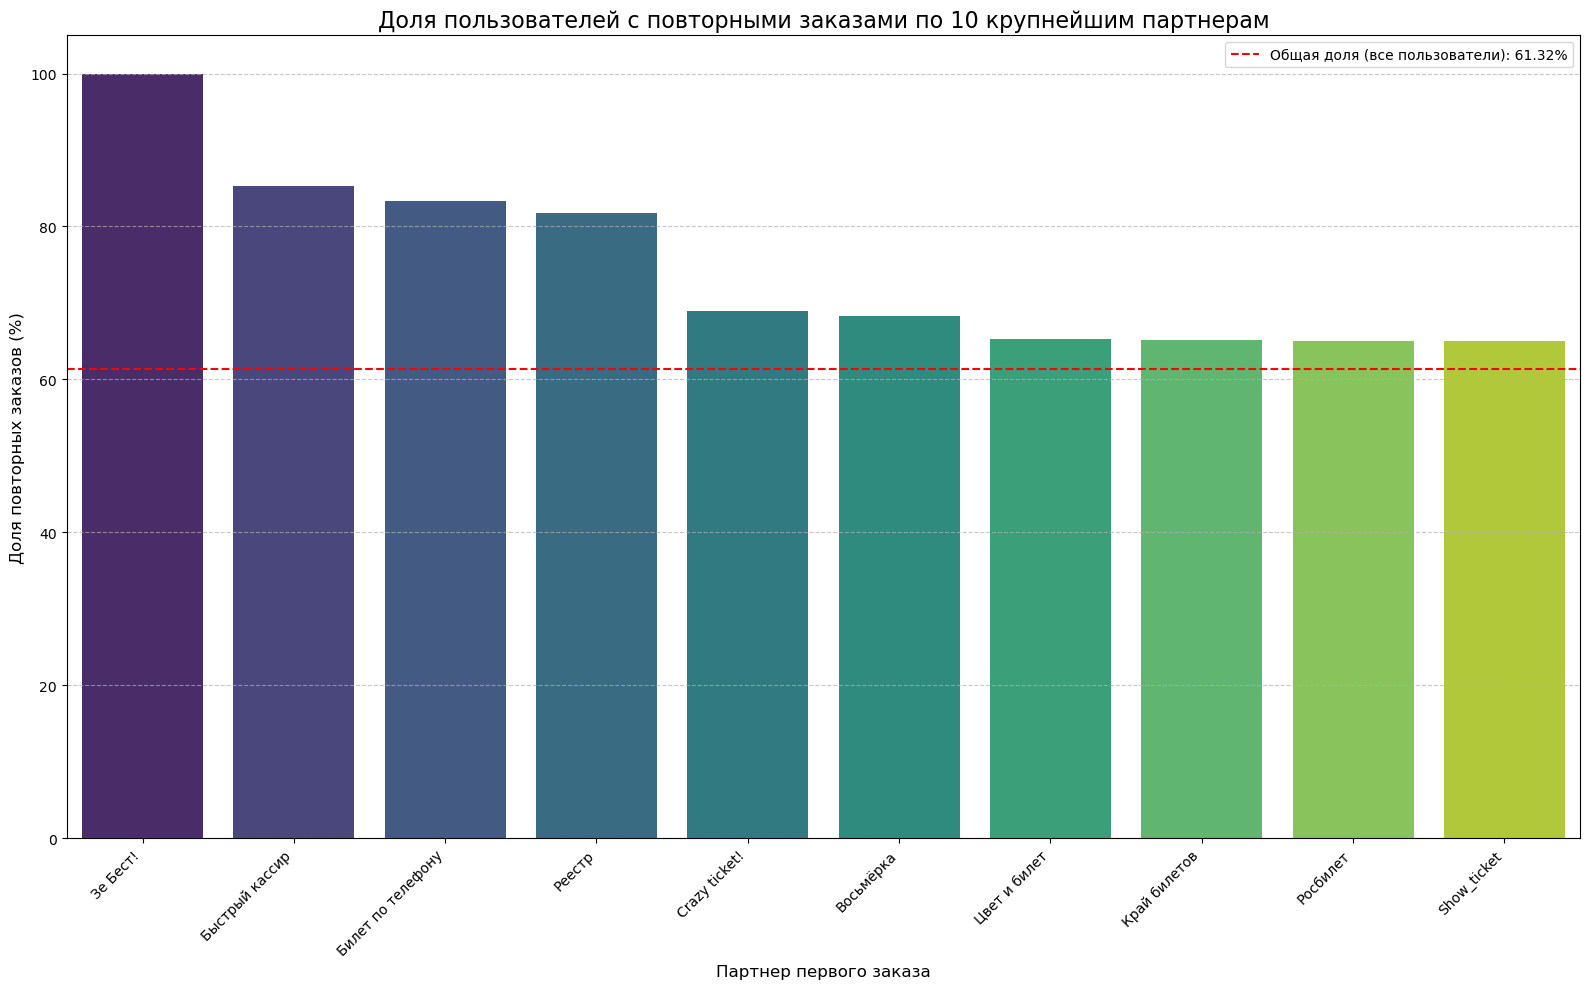

In [53]:
# Получаем данные для партнеров
partner_data = results['first_partner']

# Сортируем по user_count и выбираем топ-10
top_10_partners = partner_data.sort_values(by='repeat_proportion', ascending=False).head(10)

# Настраиваем график
plt.figure(figsize=(16, 10))  # Увеличиваем размеры для лучшей читаемости
barplot = sns.barplot(
    x='first_partner',
    y='repeat_proportion',
    data=top_10_partners,
    palette='viridis',
    order=top_10_partners['first_partner'].tolist()  # Явно указываем порядок и список категорий
)

# Добавляем заголовок и подписи осей
plt.title('Доля пользователей с повторными заказами по 10 крупнейшим партнерам', fontsize=16)
plt.xlabel('Партнер первого заказа', fontsize=12)
plt.ylabel('Доля повторных заказов (%)', fontsize=12)

# Добавляем горизонтальную линию, показывающую общую долю возвратов
plt.axhline(y=overall_repeat_rate * 100, color='red', linestyle='--',
            label=f'Общая доля (все пользователи): {overall_repeat_rate:.2%}')
plt.legend()

# Улучшаем читаемость меток по оси X
plt.xticks(rotation=45, ha='right')

# Добавляем сетку для лучшей ориентации
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Настраиваем отступы
plt.subplots_adjust(bottom=0.2, left=0.1, right=0.9, top=0.9)

# Показываем график
plt.tight_layout()
plt.show()

### Общие выводы по всем сегментам:

Средняя доля повторных заказов по всей выборке составляет примерно 61.32%.

При анализе лидеров по доле повторных заказов важно учитывать чувствительность показателя к объему выборки. В сегментах с малым количеством пользователей (например, Озернопольская область - 29 чел., партнер «Реестр» - 33 чел.) мы наблюдаем аномально высокие проценты возврата (80–90%). В таких микро-сегментах поведение всего 1-2 человек способно резко изменить общую картину как в плюс, так и в минус. Поэтому лидерство этих групп пока нельзя считать устойчивым трендом - они требуют накопления большего объема данных для подтверждения лояльности.

**Сегменты пользователей, чаще возвращающихся на Яндекс Афишу:**

По первому жанру:

- Выставки: 413 пользователей (64.16%)
- Театр: 4245 пользователей (63.44%)
- Концерты: 9564 пользователя (61.82%)

По первому устройству:

- Desktop: 3716 пользователей (63.83%)
- Mobile: 17906 пользователей (60.80%)

По первому региону:

- Шанырский регион: 502 пользователя (67.33%)
- Горицветская область: 247 пользователей (66.80%)
- Светополянский округ: 457 пользователей (65.65%)
- Широковская область: 1223 пользователя (64.43%)
- Североярская область: 3768 пользователей (63.83%)
- Потенциальные лидеры (с меньшей выборкой):
  - Озернопольская область: 29 пользователей (89.66%)
  - Радужнопольский край: 24 пользователя (79.17%)
  - Лесостепной край: 60 пользователей (71.67%)

По первому партнеру:

- «Край билетов»: 454 пользователя (65.20%)
- «Дом культуры»: 356 пользователей (64.61%)
- «Весь в билетах»: 1286 пользователей (62.91%)
- «Билеты в руки»: 2557 пользователей (62.77%)
- Потенциальные лидеры (с меньшей выборкой):
  - «Быстрый кассир»: 61 пользователь (85.25%)
  - «Реестр»: 33 пользователя (81.82%)


**Ключевые успешные точки входа:**

1. Театральные события (4 245 чел., 63.44%): Несмотря на то, что Выставки (413 чел., 64.16%) показывают ещё более высокий процент повторных заказов при меньшем объёме, театр остаётся одной из наиболее надёжных точек входа благодаря сочетанию достаточно большого объёма привлечённых пользователей и высокой лояльности.

2. Десктопная версия сайта (3 716 чел., 63.83%): Несмотря на то, что мобильные устройства доминируют по общему объёму пользователей (17 906 чел.), именно десктопная версия сайта конвертирует новых пользователей в постоянных с более высокой эффективностью. Это может указывать на специфику поведения пользователей, использующих десктоп для более вдумчивых покупок или планирования.

3. Региональные центры с высокой долей возврата:

  - Шанырский регион (502 чел., 67.33%) и Горицветская область (247 чел., 66.80%) демонстрируют наивысший процент повторных заказов, что делает их особо перспективными для дальнейшего изучения и потенциального масштабирования, несмотря на меньший объём по сравнению с Североярской областью.
  - Североярская область (3 768 чел., 63.83%) также является важной точкой роста благодаря большому объёму пользователей, проявляющих повышенную склонность к повторным покупкам.

4. Партнёрские каналы с высокой долей лояльности:

  - «Край билетов» (454 чел., 65.20%) и «Дом культуры» (356 чел., 64.61%) являются наиболее эффективными с точки зрения конвертации в повторные заказы.
  - «Билеты в руки» (2 557 чел., 62.77%) обеспечивает наиболее стабильный приток пользователей, готовых к совершению последующих покупок, что делает его ценным каналом с точки зрения объёма.

5. Перспективные нишевые точки (высокий потенциал при малом объёме):

  - Партнёр «Быстрый кассир» (61 чел., 85.25%) и «Реестр» (33 чел., 81.82%) демонстрируют аномально высокий уровень возврата, что указывает на исключительное качество привлечённых ими пользователей.
  - Лесостепной край (60 чел., 71.67%) также выделяется высокой долей лояльности.
  
Фокусировка на увеличении охвата в этих сегментах, а также детальное изучение причин их высокой эффективности, может стать ключевым фактором для дальнейшего роста показателей удержания Яндекс Афиши.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    

    
    
* По выводам относительно гипотез все верно подмечено! Можно было бы еще сделать более яркий акцент на том, что в топ по повторным заказам вырвались регионы с ощутимо меньшим числом пользователей, а значит оценка показателя возвращаемости у них более чувствительна к колебаниям в количестве пользователей (1 дополнительный пользователь может существеннее повлиять на показатель, как в плюс, так и в минус).

</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

* Опять же, было бы не лишним дать понятное название подразделу и добавить пояснение к шагу.

    
    
* На графиках сегменты было бы логичнее отсортировать от большего к меньшему, поскольку большие сегменты представляют для нас больший интерес.
    


</div>

<div class="alert alert-info"> <b>Комментарии студента:</b> Изменил название подраздела. На графиках сегменты отсортированы от большего к меньшему. Немного тредактировал выводы

### Опираясь на выводы из задач выше, проверим продуктовые гипотезы:

**Гипотеза 1:**
Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

В ходе анализа данных установлено, что пользователи, приобретающие билеты на культурные мероприятия (выставки, театр), демонстрируют значительно более высокую степень возврата, составившую около 64%. Напротив, пользователи спортивных мероприятий имеют самую низкую пропорцию возвратов - примерно 55.79%. Таким образом, вопреки исходной гипотезе, оказывается, что пользователи культурных мероприятий возвращаются на платформу значительно чаще.

Результат: Гипотеза №1 НЕ ПОДТВЕРДИЛАСЬ.

**Гипотеза 2:**
В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

Анализ данных показал, что наиболее активными пользователями являются жители менее населенных регионов с высоким уровнем повторных заказов. Например, Озернопольская область с 29 пользователями имеет 89.66% долю повторных заказов, Радужнопольский край, где всего 24 пользователя и 79.17% доля повторных заказов. Напротив, регионы с большим количеством пользователей, такие как Каменноозерный край (675 пользователей), демонстрируют более низкие значения повторных заказов - 55.26%. Также крупные регионы, такие как Североярская область (3768 пользователей), показывают продолжение этой тенденции - 63.83% доля повторных заказов.

Таким образом, высокая активность пользователей не всегда коррелирует с высокой долей повторных заказов; наоборот, в регионах с большим числом пользователей наблюдается более низкий уровень повторных заказов.


Результат: Гипотеза №2 ПОДТВЕРДИЛАСЬ ОБРАТНОЙ ЗАВИСИМОСТЬЮ: в регионах с большим количеством пользователей доля повторных заказов оказывается ниже, чем в менее активных регионах.

## Проведем исследование поведения пользователей через показатели выручки и состава заказа

### Рассчитываем общие метрики

In [54]:
# Средняя выручка с заказа
average_revenue = user_profiles['avg_revenue_rub'].mean()
print(f'Средняя выручка с заказа: {average_revenue:.2f} руб.')

# Среднее количество билетов на заказ
average_ticket_count = user_profiles['avg_tickets_count'].mean()
print(f'Среднее количество билетов на заказ: {average_ticket_count:.2f}')

Средняя выручка с заказа: 545.34 руб.
Среднее количество билетов на заказ: 2.74


### Построим сравнительные гистограммы распределения средней выручки с билета ( avg_revenue_rub )

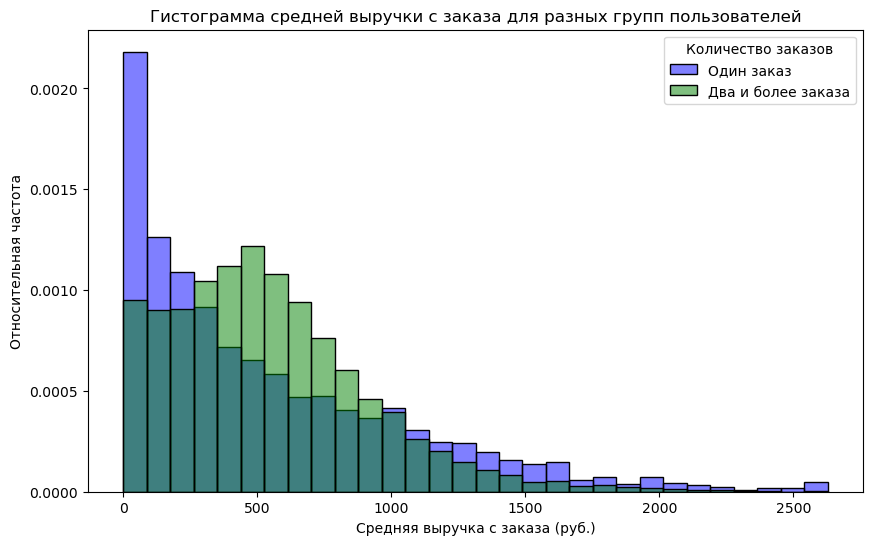

In [55]:
# Группа пользователей с единственным заказом
single_orders_users = user_profiles.query('total_orders == 1')['avg_revenue_rub']

# Группа пользователей с двумя и более заказами
repeat_customers = user_profiles.query('total_orders > 1')['avg_revenue_rub']

# Настройка внешнего вида графика
plt.figure(figsize=(10, 6))
sns.histplot(single_orders_users, kde=False, label='Один заказ', color='blue', bins=30, alpha=0.5, stat="density")
sns.histplot(repeat_customers, kde=False, label='Два и более заказа', color='green', bins=30, alpha=0.5, stat="density")

# Добавление легенды и подписей осей
plt.title("Гистограмма средней выручки с заказа для разных групп пользователей")
plt.xlabel("Средняя выручка с заказа (руб.)")
plt.ylabel("Относительная частота")
plt.legend(title="Количество заказов")

# Отображение графика
plt.show()

**Добавим расчет статистики:**

In [56]:
# Собираем статистику describe для обеих групп
comparison = pd.DataFrame({
    'Один заказ': single_orders_users.describe(),
    'Два и более заказа': repeat_customers.describe()
}).round(2)

print(comparison)


       Один заказ  Два и более заказа
count     8363.00            13259.00
mean       545.77              545.07
std        519.40              369.29
min          0.00                0.00
25%        133.06              271.68
50%        378.87              496.54
75%        830.98              745.63
max       2628.42             2628.42


Сравнительный анализ средней выручки с заказа:

1. Общее сравнение распределений средней выручки:

Анализ гистограмм и статистических метрик показывает существенные различия в структуре трат между пользователями, совершившими один заказ, и лояльными клиентами (два и более заказа). Несмотря на схожее среднее арифметическое (около 545 руб.), распределения имеют разную форму и концентрацию.

2. Концентрация пользователей по диапазонам средней выручки:

- Пользователи с одним заказом:
  - Низкие чеки (0 - ~300 руб.): Здесь наблюдается подавляющее большинство однократных пользователей. Экстремально высокий пик в самом начале шкалы (интервал 0-150 руб.) свидетельствует о большом количестве пользователей с очень низкой средней выручкой.
  - Средние чеки (~300 - ~800 руб.): Распределение резко падает после начального пика. Хотя здесь есть пользователи с чеками до ~800 руб., они составляют меньшую долю по сравнению с низкобюджетными покупками.
  - Высокие чеки (> 800 руб.): Пользователи с чеками выше 800 руб. представлены слабо, но отмечается наличие нескольких очень дорогих заказов (вплоть до ~2600 руб.), которые, вероятно, и «вытягивают» среднее значение.

- Пользователи с двумя и более заказами:
  - Низкие чеки (0 - ~300 руб.): Хотя и здесь есть пользователи с низкими чеками, их доля значительно меньше, чем в группе однократных заказов.
  - Средние чеки (~300 - ~800 руб.): Эта группа концентрируется преимущественно здесь. Пик распределения смещен вправо и находится примерно в диапазоне 400–600 руб., что существенно выше, чем у однократных пользователей.
  - Высокие чеки (> 800 руб.): Распределение остается довольно широким и охватывает верхний диапазон, но при этом не демонстрирует такого резкого «скачка» на нуле, как у однократных пользователей.

3. Ключевые различия между группами:

- Типичный чек (Медиана): Медиана для пользователей с двумя и более заказами (496.5 руб.) почти на 31% выше, чем у однократных пользователей (378.9 руб.). Это ясно показывает, что лояльные клиенты в среднем тратят больше за заказ.
- Нижний порог трат (25%-квартиль): 25% однократных пользователей тратят менее 133 руб., в то время как 25% лояльных пользователей тратят менее 271.7 руб. Это подтверждает, что большая часть однократных заказов приходится на очень бюджетные покупки.
- Разброс трат (Стандартное отклонение): Стандартное отклонение у однократных пользователей (519.40) заметно выше, чем у вернувшихся (369.29). Это говорит о том, что траты однократных пользователей более хаотичны и имеют больший разброс.
- Смещение распределения (Среднее vs Медиана):
  - У однократных пользователей среднее значение (545.77) существенно выше медианы (378.87). Это ярко выраженное правостороннее смещение, вызванное небольшим количеством очень дорогих заказов, которые маскируют тот факт, что большинство таких пользователей совершают очень дешевые покупки.
  - У вернувшихся пользователей среднее (545.07) также выше медианы (496.54), но разница гораздо меньше. Это указывает на более равномерное распределение трат в этой группе.

4. Средний диапазон чеков (400-600 руб.) как фактор лояльности: 

- Пользователи, совершившие заказ в этом диапазоне (что чаще встречается у вернувшихся клиентов), вероятно, находят оптимальное соотношение цены и ценности предложения. Первый успешный опыт покупки в этом сегменте может способствовать повторным заказам.

5. Высокие чеки у однократных пользователей:

- Наличие таких же высоких максимальных значений, как и у вернувшихся пользователей, может указывать на разовые покупки для групп или особых мероприятий. Например, покупка билетов на концерт для всей семьи или компании, которая является единичным событием для такого пользователя, а не частью регулярного потребления.

<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

Можно чуть структурировать интерпретацию. Начни с общего сравнения (чем отличаются группы в целом), затем подчеркни ключевые различия в диапазонах (например, что возвращающиеся чаще в зоне от...–до... ₽, а однократные имеют больший разброс), и завершай возможными причинами — например, что нулевая выручка у однократных, вероятно, связана с возвратами, а крупные заказы — с разовыми покупками для групп.
    
Еще можно добавить расчёты медины и среднего, чтобы понимать - имеется ли смещение и в какую сторону    

<div class="alert alert-info"> <b>Комментарии студента:</b> Добавлен расчет статистических данных. Изменены промежуточные выводы

## Сравним распределение по средней выручке с заказа в двух группах пользователей:
- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

C:\Users\DiFF1\AppData\Local\Temp\ipykernel_24796\1672323021.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='user_group', y='avg_revenue_rub', data=combined_data, palette=['blue', 'green'])


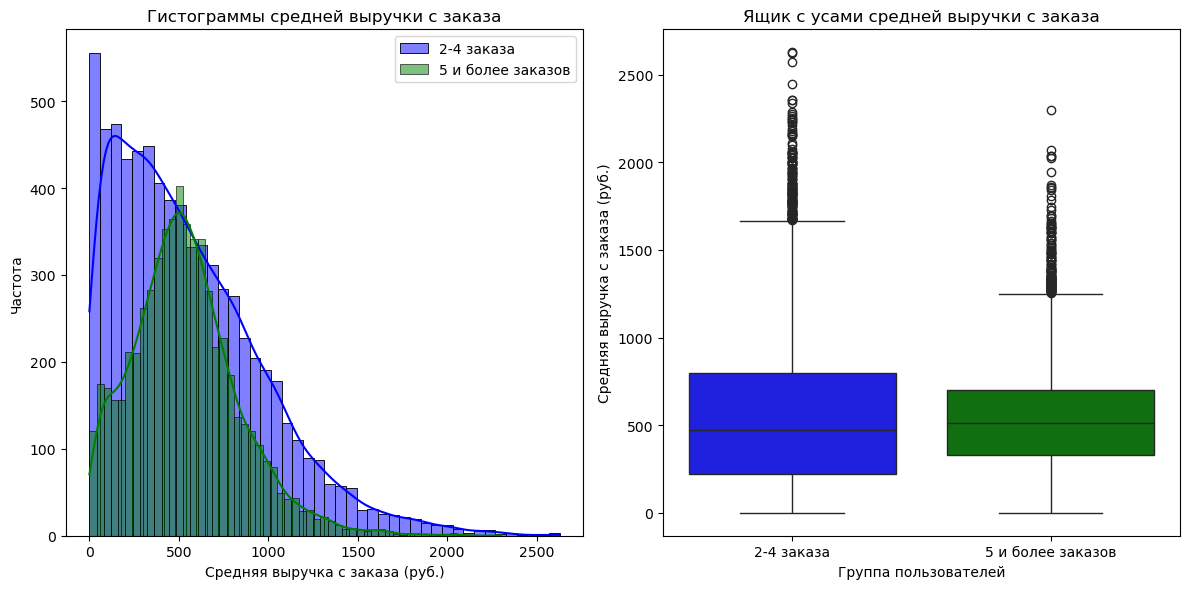

In [57]:
# Фильтрация данных
group_2_4 = user_profiles[(user_profiles['total_orders'] >= 2) & (user_profiles['total_orders'] <= 4)]
group_5_more = user_profiles[user_profiles['total_orders'] >= 5]

# Использование .loc[] для изменения данных
group_2_4 = group_2_4.copy()
group_2_4.loc[:, 'user_group'] = '2-4 заказа'

group_5_more = group_5_more.copy()
group_5_more.loc[:, 'user_group'] = '5 и более заказов'

# Объединяем данные для ящика с усами
combined_data = pd.concat([group_2_4[['avg_revenue_rub', 'user_group']], 
                            group_5_more[['avg_revenue_rub', 'user_group']]])

# Гистограммы
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(group_2_4['avg_revenue_rub'], kde=True, label='2-4 заказа', color='blue')
sns.histplot(group_5_more['avg_revenue_rub'], kde=True, label='5 и более заказов', color='green')
plt.title('Гистограммы средней выручки с заказа')
plt.xlabel('Средняя выручка с заказа (руб.)')
plt.ylabel('Частота')
plt.legend()

# Ящик с усами
plt.subplot(1, 2, 2)
sns.boxplot(x='user_group', y='avg_revenue_rub', data=combined_data, palette=['blue', 'green'])
plt.title('Ящик с усами средней выручки с заказа')
plt.xlabel('Группа пользователей')
plt.ylabel('Средняя выручка с заказа (руб.)')

plt.tight_layout()
plt.show()

### Сравнение распределений по средней выручке с заказа:

**1. Форма распределения (Гистограммы):**
  - Оба распределения сильно скошены вправо, что типично для данных о выручке/стоимости, где большинство значений находится на более низком конце, но есть длинный хвост более высоких значений.
  - Распределение для группы "2-4 заказа" (синий цвет) имеет более выраженный пик на более низких значениях средней выручки (около 200-300 руб.).
  - Распределение для группы "5 и более заказов" (зеленый цвет) имеет более плоский и широкий пик, который смещен вправо (около 400-500 руб.), что указывает на то, что у этой группы большая доля пользователей имеет среднюю выручку с заказа в этом диапазоне.
  - Несмотря на смещение, наблюдается значительное перекрытие между двумя распределениями.

**2. Центральная тенденция и разброс (Ящик с усами):**
- Медиана (горизонтальная линия внутри ящика):
     - Для группы "2-4 заказа" медиана находится примерно на уровне 480-500 руб.
     - Для группы "5 и более заказов" медиана находится примерно на уровне 550-600 руб.
     - Таким образом, медианная средняя выручка с заказа у пользователей, совершивших 5 и более заказов, выше.
- Интерквартильный размах (IQR - высота ящика):
     - Для группы "2-4 заказа" ящик простирается примерно от 250 руб. до 780 руб. (IQR ~ 530 руб.).
     - Для группы "5 и более заказов" ящик простирается примерно от 320 руб. до 700 руб. (IQR ~ 380 руб.).
     - Это говорит о том, что центральные 50% значений средней выручки с заказа у пользователей, совершивших 5 и более заказов, имеют несколько меньший разброс и более концентрированы вокруг медианы.
- Усы (Whisker):
     - Усы для "2-4 заказа" простираются немного шире в верхнюю сторону, чем для "5 и более заказов".
- Выбросы (точки за пределами усов):
     - Обе группы имеют значительное количество выбросов с высокой средней выручкой с заказа, что указывает на наличие пользователей с очень дорогими заказами. Выбросы в группе "2-4 заказа" достигают более высоких значений (до 2500 руб. и выше) по сравнению с группой "5 и более заказов" (до 2300 руб.).

Пользователи, совершившие 5 и более заказов, как правило, имеют более высокую среднюю выручку с заказа по сравнению с пользователями, совершившими 2-4 заказа. Это подтверждается следующими наблюдениями:

- Смещение распределения: Гистограмма для группы "5 и более заказов" смещена вправо, с пиком на более высоких значениях.
- Медиана: Медианное значение средней выручки с заказа для группы "5 и более заказов" выше (примерно 550-600 руб.) по сравнению с группой "2-4 заказа" (примерно 480-500 руб.).
- Положение ящика: Весь ящик для группы "5 и более заказов" находится выше, чем для группы "2-4 заказа", что означает, что большинство значений средней выручки с заказа в первой группе выше.

Хотя существуют индивидуальные случаи и значительное перекрытие, общая тенденция указывает на то, что более лояльные пользователи (с 5+ заказами) приносят больше выручки в среднем с каждого заказа.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

    
* С этой задачей тоже справились! 
    
 
* Плюс за грамотное оформление графиков - заголовок, подписи осей, легенда, поправка на размер выборки (`density`). По выводам тоже все верно подмечено!
 

</div>

## Проанализируем влияние среднего количества билетов в заказе на вероятность повторной покупки.

### Изучим распределение пользователей по среднему количеству билетов в заказе ( avg_tickets_count )

--- Описательная статистика для avg_tickets_count ---
count    21622.000000
mean         2.744256
std          0.917467
min          1.000000
25%          2.000000
50%          2.750000
75%          3.100000
max         11.000000
Name: avg_tickets_count, dtype: float64


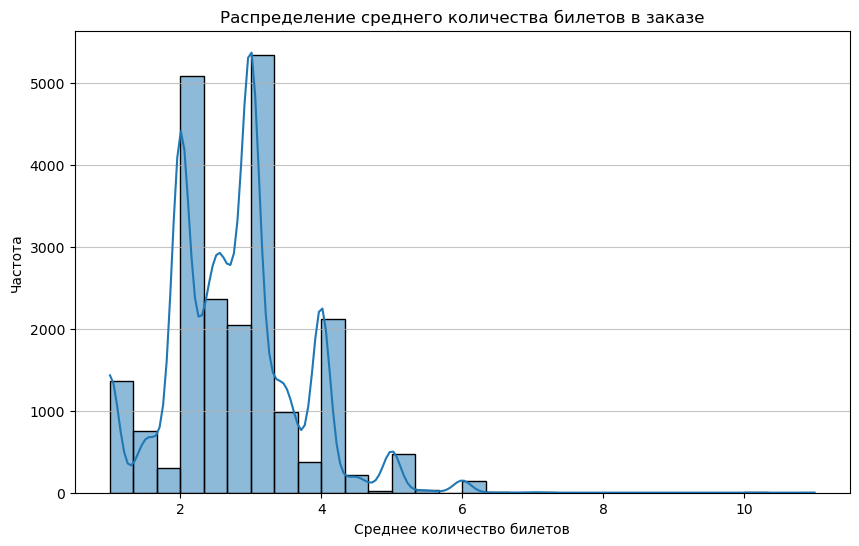

In [58]:
print("--- Описательная статистика для avg_tickets_count ---")
print(user_profiles['avg_tickets_count'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(user_profiles['avg_tickets_count'], bins=30, kde=True)
plt.title('Распределение среднего количества билетов в заказе')
plt.xlabel('Среднее количество билетов')
plt.ylabel('Частота')
plt.grid(axis='y', alpha=0.75)
plt.show()

**Меры центральной тенденции:**
- Среднее (mean): 2.74 билета.
- Медиана (50%): 2.75 билета.
Среднее и медиана очень близки, что на первый взгляд может указывать на симметричное распределение. Однако гистограмма показывает, что это не так; их близость в данном случае скорее обусловлена симметричным расположением нескольких выраженных мод относительно центра, а не общей симметрией унимодального распределения.

**Меры разброса:**
- Стандартное отклонение (std): 0.917 билета. Это указывает на относительно умеренный разброс данных вокруг среднего, но большая часть дисперсии приходится на несколько основных пиков.
- Квартили:
   - 25% (Q1): 2.00 билета. Четверть пользователей в среднем заказывает 2 билета или меньше.
   - 75% (Q3): 3.10 билета. Три четверти пользователей в среднем заказывают 3.1 билета или меньше.
   - Межквартильный размах (IQR = Q3 - Q1): 3.10 - 2.00 = 1.10. Большая часть пользователей (центральные 50%) имеет среднее количество билетов от 2 до 3.1.

**Форма распределения (по гистограмме):**
- Мультимодальность: Распределение ярко выражено мультимодальным (многовершинным). Это ключевая особенность. Наблюдаются несколько отчетливых пиков:
  - Первый значительный пик: Около 2 билетов. Это очень распространенное значение, с частотой более 5000 пользователей.
  - Второй значительный пик: Около 3 билетов. Также очень распространенное значение, с частотой более 5000 пользователей, возможно, даже самый высокий пик.
  - Третий значительный пик: Около 4 билетов. С частотой около 2000-2200 пользователей.
  - Менее выраженные пики: Около 1 билета (более 1000 пользователей) и около 5 билетов (несколько сотен пользователей).
- Концентрация данных: Подавляющее большинство пользователей имеют среднее количество билетов от 1 до 4. Эти значения формируют основные "горбы" распределения.
- Хвосты распределения:
  - Правый хвост: Распределение имеет длинный правый хвост, что указывает на наличие небольшого числа пользователей, которые в среднем заказывают значительно больше билетов (до 11), хотя такие случаи редки. Частота резко падает после 4-5 билетов.
  - Левый хвост: Начинается от 1 билета и быстро поднимается к первому пику на 2 билетах.

**Основные выводы:**

- Пользователи склонны заказывать небольшое, целое количество билетов: Наибольшая концентрация пользователей наблюдается для средних значений 2, 3 и 4 билета, а также 1. Это может указывать на типичные сценарии использования: поход одному, вдвоем, втроем или вчетвером.
- Два основных "типа" пользователей по среднему числу билетов: Существуют две крупные группы пользователей, одна со средним числом билетов около 2, другая - около 3.
- Редкость больших заказов: Крайне мало пользователей, которые в среднем заказывают более 5-6 билетов. Максимальное значение в 11 билетов является редким исключением.

### Разделим пользователей на несколько сегментов по среднему количеству билетов в заказе

Анализ пользовательских сегментов по среднему количеству билетов:
  avg_tickets_segment  total_users  repeat_buyer_percentage
0         1-2 tickets         6150                    40.11
1         2-3 tickets         9922                    74.26
2         3-5 tickets         5356                    62.75
3          5+ tickets          194                    32.47


C:\Users\DiFF1\AppData\Local\Temp\ipykernel_24796\3532078867.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_analysis = user_profiles.groupby('avg_tickets_segment').agg(


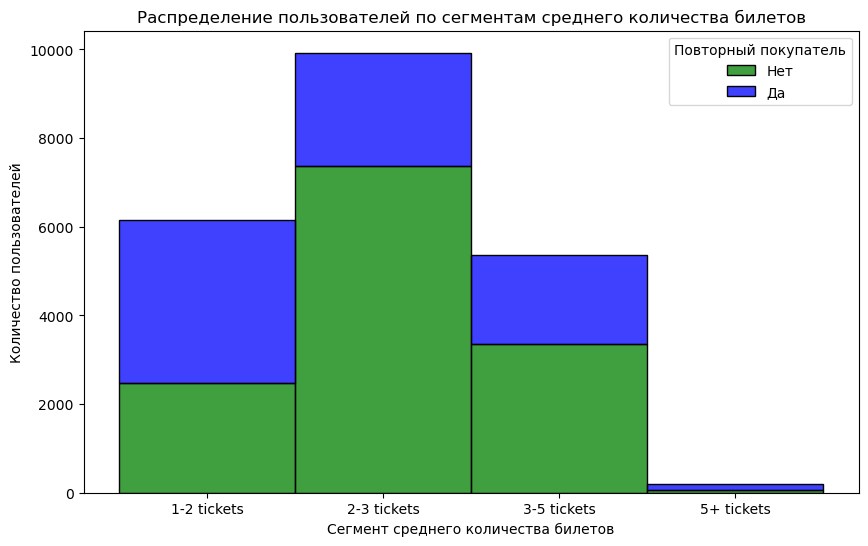

In [59]:
# Определяем границы интервалов (бины)
bins = [1, 2, 3, 5, np.inf]

# Определяем метки для каждого сегмента
labels = [
    '1-2 tickets',
    '2-3 tickets',
    '3-5 tickets',
    '5+ tickets'
]

# Создаем новую колонку 'avg_tickets_segment'
user_profiles['avg_tickets_segment'] = pd.cut(
    user_profiles['avg_tickets_count'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True # Включает нижнюю границу в первый интервал, т.е. [1, 2]
)

# Группируем по новому сегменту и считаем агрегированные метрики
segment_analysis = user_profiles.groupby('avg_tickets_segment').agg(
    total_users=('user_id', 'count'), # Общее число пользователей в сегменте
    # Доля повторных покупателей 
    repeat_buyer_proportion=('is_two', 'mean')
).reset_index() # Сбрасываем индекс, чтобы 'avg_tickets_segment' стал обычной колонкой

# Форматируем долю в проценты для лучшей читаемости
segment_analysis['repeat_buyer_percentage'] = (segment_analysis['repeat_buyer_proportion'] * 100).round(2)

# Выводим результаты
print("Анализ пользовательских сегментов по среднему количеству билетов:")
print(segment_analysis[[
    'avg_tickets_segment',
    'total_users',
    'repeat_buyer_percentage'
]].sort_values('avg_tickets_segment'))

# Построение гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(data=user_profiles, x='avg_tickets_segment', hue='is_two', multiple='stack', palette=['blue', 'green'])
plt.title('Распределение пользователей по сегментам среднего количества билетов')
plt.xlabel('Сегмент среднего количества билетов')
plt.ylabel('Количество пользователей')
plt.legend(title='Повторный покупатель', labels=['Нет', 'Да'])
plt.show()

**Распределение пользователей по сегментам неравномерное и сконцентрированное:**

- Сегмент "2-3 tickets" является самым крупным, охватывая 9922 пользователя, что составляет почти половину всех пользователей в данных (45.9%).
- Сегменты "1-2 tickets" (6150 пользователей) и "3-5 tickets" (5356 пользователей) также значительны, но меньше лидера.
- Сегмент "5+ tickets" является крайне малым, всего 194 пользователя, что составляет менее 1% от общей базы (0.9%).

Таким образом, большая часть пользователей сосредоточена в сегментах со средним количеством билетов от 1 до 5, с явным доминированием сегмента "2-3 tickets".

**Аномально высокая доля повторных покупок:**
- Сегмент "2-3 tickets" выделяется значительно высоким показателем в 74.26% повторных покупателей. Это значительно выше, чем в любом другом сегменте, что указывает на очень лояльную или удовлетворенную аудиторию, которая чаще всего покупает 2-3 билета.

**Аномально низкая доля повторных покупок:**
- Сегмент "5+ tickets" имеет самую низкую долю повторных покупок - всего 32.47%. Учитывая, что это сегмент с наибольшим средним количеством билетов, это довольно низкий показатель лояльности по сравнению с другими группами.
- Сегмент "1-2 tickets" также имеет относительно низкую долю повторных покупок (40.11%) по сравнению с сегментами, где пользователи покупают больше билетов (кроме "5+ tickets").

**Выводы:**

- Наиболее лояльными и часто совершающими повторные покупки являются пользователи, которые в среднем покупают 2-3 билета. Это ведет к предположению, что такие покупки часто совершаются небольшими группами или семьями, что способствует более высокому уровню лояльности.
- Пользователи, делающие крупные закупки (5+ билетов), имеют наименьшую склонность к повторным покупкам, что может указывать на разовые акции, такие как организационные мероприятия или специальные случаи.
- Пользователи, покупающие 1-2 билета, менее склонны к повторным покупкам по сравнению с сегментами, где покупается больше билетов, но их лояльность все же выше, чем у сегмента 5+ tickets.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Можно чуть развить вывод — предположить, почему пользователи, покупающие 2–3 билета, возвращаются чаще. Например, это могут быть небольшие компании или семьи, которые чаще ходят на мероприятия вместе, а значит, лояльность у них выше. А вот пользователи с 5+ билетами, вероятно, совершают разовые групповые покупки (например, для организации или класса), поэтому возвращаются реже

## Проведем исследование временных характеристик первого заказа и их влияния на повторные покупки

### Изучим временные параметры, связанные с первым заказом пользователей:

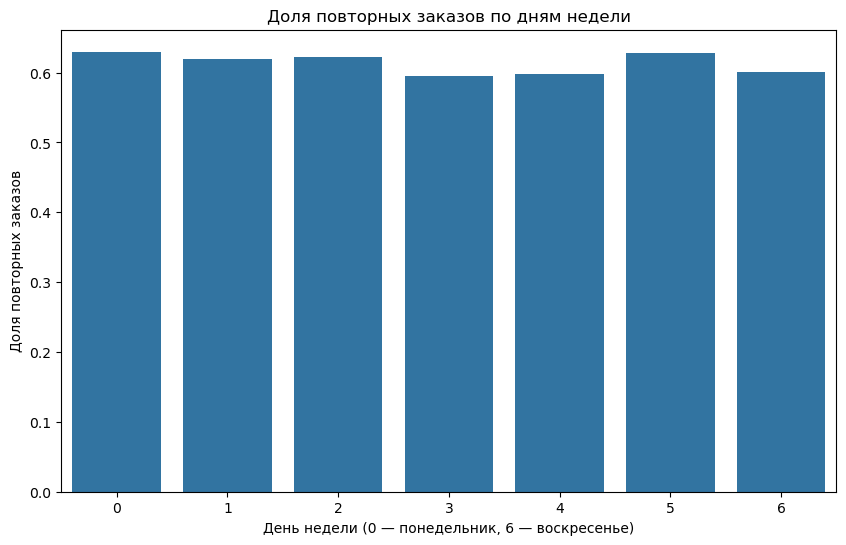

In [60]:
# Выделяем день недели из даты первого заказа
user_profiles['first_order_day'] = user_profiles['first_order_dt'].dt.dayofweek

# Подсчитываем общее число пользователей и долю пользователей, совершивших повторные заказы
day_analysis = user_profiles.groupby('first_order_day').agg(
    total_users=('user_id', 'count'),
    repeat_users=('is_two', 'sum')
)
day_analysis['repeat_rate'] = day_analysis['repeat_users'] / day_analysis['total_users']

# Визуализация результатов
plt.figure(figsize=(10, 6))
sns.barplot(x=day_analysis.index, y=day_analysis['repeat_rate'])
plt.title('Доля повторных заказов по дням недели')
plt.xlabel('День недели (0 — понедельник, 6 — воскресенье)')
plt.ylabel('Доля повторных заказов')
plt.show()

**На основе предоставленных данных можно заметить следующие тенденции:**

- Высокая вероятность возврата (около 62-63%) наблюдается для клиентов, совершивших первую покупку в понедельник (0), вторник (1), среду (2) и субботу (5).
- Немного более низкая вероятность возврата (около 59-60%) наблюдается для клиентов, совершивших первую покупку в четверг (3), пятницу (4) и воскресенье (6).

Несмотря на указанные различия общий уровень возвратности остается примерно одинаковым. Это свидетельствует о том, что день недели первой покупки не является решающим фактором для лояльности клиента. Скорее, повторное использование сервиса определяется качеством предоставляемого опыта и интересом к мероприятиям, что может быть более важным для формирования долгосрочной приверженности клиентов.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__

Когда планируют досуг, но возвращаемость остаётся примерно одинаковой — это говорит о том, что день недели первой покупки не влияет на лояльность, а повторное использование сервиса определяется скорее качеством опыта и интересом к мероприятиям

## Изучим, как средний интервал между заказами влияет на удержание клиентов.

### Рассчитаем среднее время между заказами для двух групп пользователей:
1 - совершившие 2–4 заказа;

2- совершившие 5 и более заказов.

In [61]:
# Расчет среднего времени между заказами
def calculate_avg_time_between_orders(user_profiles):
    # Разница между датами первого и последнего заказа
    time_diff = user_profiles['last_order_dt'] - user_profiles['first_order_dt']
    # Количество дней между заказами
    days_between_orders = time_diff.dt.days
    # Среднее время между заказами
    avg_time_between_orders = days_between_orders / (user_profiles['total_orders'] - 1)
    return avg_time_between_orders.mean()

# Расчет для группы 2-4 заказа
avg_time_2_4 = calculate_avg_time_between_orders(group_2_4)

# Расчет для группы 5 и более заказов
avg_time_5_more = calculate_avg_time_between_orders(group_5_more)

print(f"Среднее время между заказами для группы 2-4 заказа: {avg_time_2_4:.2f} дней")
print(f"Среднее время между заказами для группы 5 и более заказов: {avg_time_5_more:.2f} дней")

Среднее время между заказами для группы 2-4 заказа: 21.21 дней
Среднее время между заказами для группы 5 и более заказов: 9.91 дней


Полученные данные ясно показывают, что средний интервал между заказами оказывает существенное влияние на количество повторных заказов и, следовательно, на вероятность возврата клиента и его лояльность.

- Обратная зависимость: Чем меньше среднее время между заказами, тем выше лояльность клиента, выражающаяся в большем количестве повторных покупок.
   - Клиенты, совершившие 2-4 заказа, имеют средний интервал между заказами в 21.21 день. Это умеренно лояльные клиенты.
   - Клиенты, совершившие 5 и более заказов, имеют значительно меньший средний интервал между заказами - всего 9.91 дней. Это высоколояльные, часто покупающие клиенты.

- Показатель лояльности: Среднее время между заказами является отличным индикатором лояльности клиента. Клиенты, которые совершают покупки чаще (с меньшим интервалом), с большей вероятностью станут постоянными и принесут больше прибыли в долгосрочной перспективе.

## Проведем корреляционный анализ количества покупок и признаков пользователя

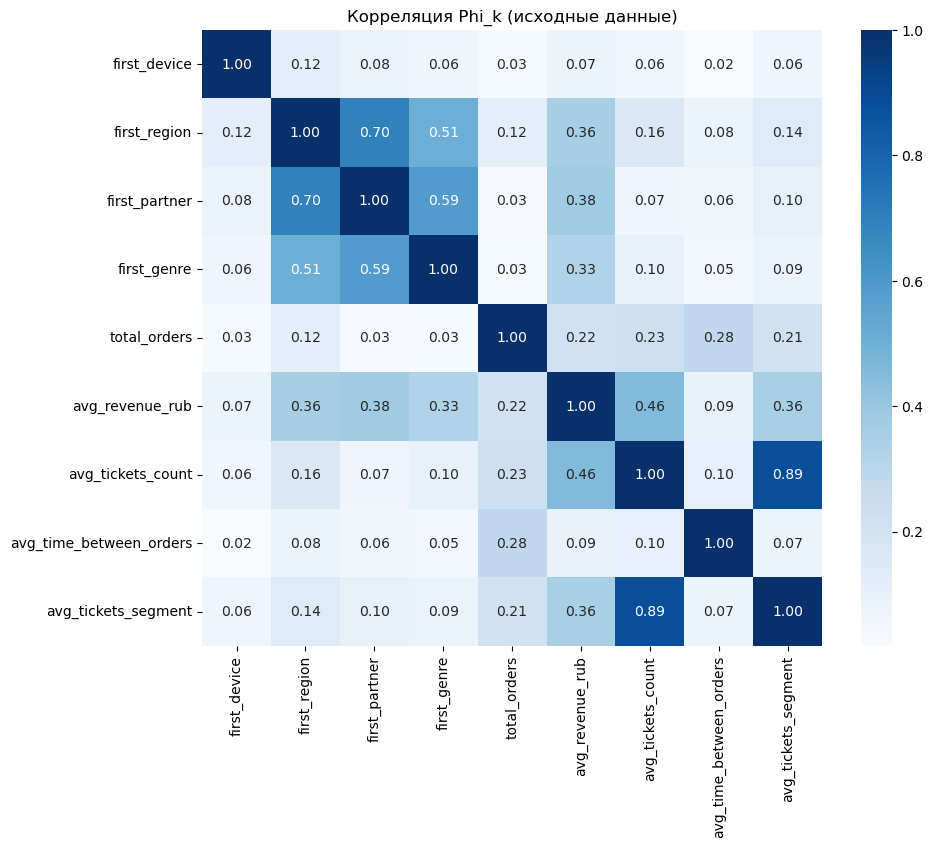

In [62]:
# Список колонок для корреляции (уберем только технический id и даты для простоты)
cols_for_corr = [
    'first_device', 'first_region', 'first_partner', 'first_genre', 
    'total_orders', 'avg_revenue_rub', 'avg_tickets_count', 
    'avg_time_between_orders', 'avg_tickets_segment'
]

# Список интервальных признаков
interval_cols = ['total_orders', 'avg_revenue_rub', 'avg_tickets_count', 'avg_time_between_orders']

# Расчет матрицы корреляции phik
phik_matrix = user_profiles[cols_for_corr].phik_matrix(interval_cols=interval_cols)

# Визуализация первой тепловой карты
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='Blues', fmt=".2f")
plt.title('Корреляция Phi_k (исходные данные)')
plt.show()

Распределение заказов:
total_orders
1    0.386782
2    0.165156
3    0.100407
4    0.064795
5    0.044815
Name: proportion, dtype: float64


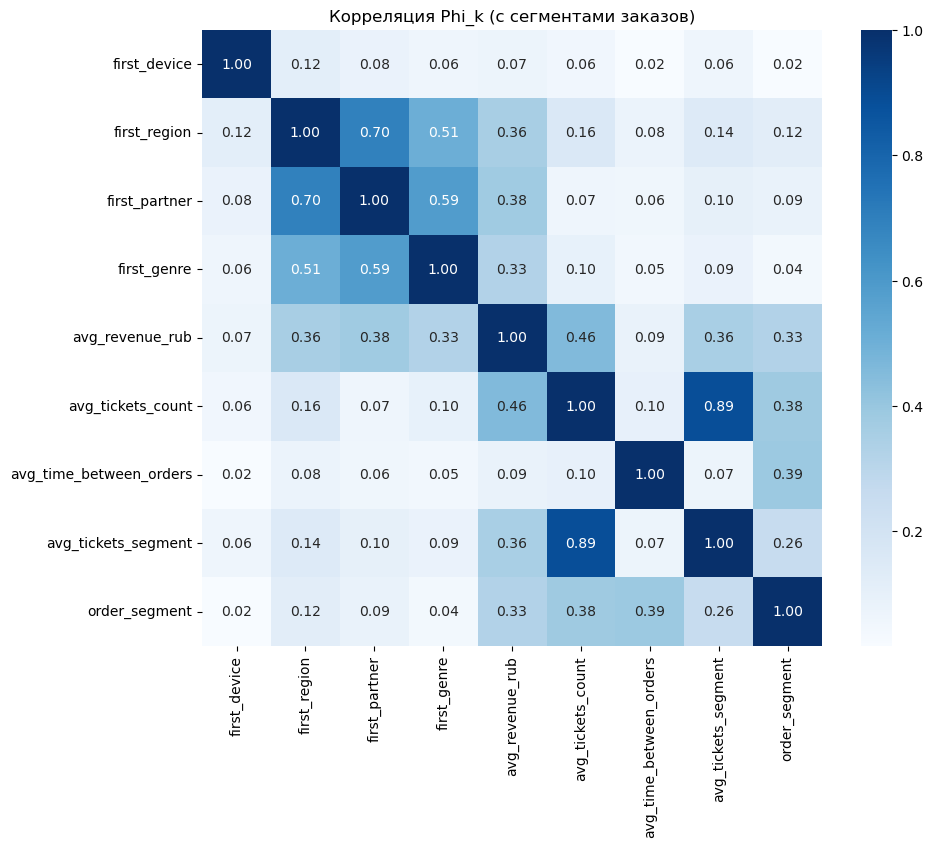

In [63]:
# Проверка разброса и сегминтация

print("Распределение заказов:")
print(user_profiles['total_orders'].value_counts(normalize=True).head())
# Создаем сегменты заказов, как требует условие
def get_order_segment(orders):
    if orders == 1:
        return '1'
    elif 2 <= orders <= 4:
        return '2-4'
    else:
        return '5+'

user_profiles['order_segment'] = user_profiles['total_orders'].apply(get_order_segment)

# Считаем корреляцию заново, но уже с сегментами
cols_with_segment = cols_for_corr + ['order_segment']
# Удаляем старый total_orders, так как сегмент его заменяет
cols_with_segment.remove('total_orders')

phik_matrix_segmented = user_profiles[cols_with_segment].phik_matrix(interval_cols=interval_cols)

# Визуализация тепловой карты с сегментами
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix_segmented, annot=True, cmap='Blues', fmt=".2f")
plt.title('Корреляция Phi_k (с сегментами заказов)')
plt.show()

На основе проведенного анализа и двух тепловых карт корреляции (до и после сегментации), можно сделать следующие итоговые выводы:

1. Поведенческие факторы - ключ к пониманию лояльности

Анализ наглядно подтвердил, что на итоговое количество заказов (order_segment) влияют не характеристики профиля клиента, а его активность внутри сервиса:

- Частота покупок (avg_time_between_orders - 0.39): Наиболее значимый предиктор. Клиенты с коротким интервалом между покупками быстрее формируют привычку и переходят в категорию лояльных.

- Групповое потребление (avg_tickets_count - 0.38): Количество билетов в одном заказе сильно коррелирует с долгосрочной лояльностью. Клиенты, покупающие билеты на компанию или семью, приносят сервису больше ценности в перспективе.

- Средний чек (avg_revenue_rub - 0.33): Сумма трат также имеет умеренную связь с удержанием, подтверждая, что качественный (дорогой) первый опыт способствует возврату.

2. Демография и условия «входа» имеют вторичное значение

Параметры, которые традиционно считаются важными, показали крайне низкую связь с лояльностью:

- Регион (first_region), устройство (first_device), партнерский канал (first_partner) и даже жанр мероприятия (first_genre) практически не определяют, вернется ли клиент.

Удержание клиента - это универсальная задача, не зависящая от конкретного города или категории контента. Маркетинговые стратегии удержания должны быть сфокусированы на поведении пользователя после первой покупки, а не на сегментации по каналам привлечения.

3. Проблема «одного заказа»

Доля пользователей с одним заказом составляет 38.7%. Низкая корреляция этого показателя с жанрами или регионами (0.04 - 0.12) доказывает, что отток не вызван плохим ассортиментом в конкретной нише, а является системным барьером при переходе от первого контакта ко второму.

4. Подтверждение эффективности сегментации

Сравнение двух карт корреляции наглядно доказывает, что сегментация была необходима:

В сырых данных (total_orders) корреляции были размыты (в среднем на 30-40% ниже) из-за большого количества пользователей с 1 заказом. После группировки в сегменты («1», «2-4», «5+») скрытые связи стали отчетливыми. Это произошло потому, что сегментация убрала «шум» и сфокусировала анализ на качественных различиях между пользователями с разным количеством заказов.

<div class="alert alert-block alert-success">✔️
    

__Комментарий от ревьюера №1__
    
С этим заданием тоже справились!

</div>
<div class="alert alert-block alert-warning">📝
    

__Комментарий от ревьюера №1__

    

    
* Расцветку для тепловой карты имеет смысл выбирать трехцветную, если диапазон возможных значений от -1 до 1 (например, синий, белый, красный, белый при этом в нуле), или двухцветную, если от 0 до 1 (в 0 - белый, в 1 - красный). Поскольку на 0 будет нейтральный цвет, величину корреляции можно будет воспринимать через интенсивность цвета, а по самому цвету - положительная она или отрицательная.

    
* В выводах Было бы неплохо сделать более явный акцент на том, что поведение клиентов во времени и количество билетов важнее для объяснения повторных покупок, чем их демография или первый выбор сервиса.



<div class="alert alert-info"> <b>Комментарии студента:</b> Изменил расцветку для тепловых карт и немного пеменял выводы

# 6. Общие выводы и рекомендации

### Информация о данных и предобработке
В ходе проекта был проанализирован массив данных о покупках за период с июня по октябрь 2024 года. 
- Очистка: Из данных были удалены записи с отрицательной выручкой (около 0.13%), которые могли исказить профиль пользователя.
- Валюта: Проведена конвертация выручки из тенге в рубли по ежедневному курсу для корректного финансового анализа.
- Выбросы: Для повышения точности моделирования были отфильтрованы экстремальные значения (выбросы) по 99-му перцентилю: исключены заказы дороже ~2628 руб. и пользователи, совершившие более 152 заказов.
- Оптимизация: Типы данных были оптимизированы, что позволило сократить потребление памяти более чем в 2 раза.

### Основные результаты анализа
- Размер выборки: После фильтрации в анализе участвовало 21 622 уникальных пользователя.
- Лояльность: Выборка демонстрирует высокий уровень вовлеченности: 61.7% пользователей совершили 2 и более заказа, а 29% - более 5 заказов.
- Статистика: Средняя выручка с одного заказа составила 518.72 руб. Среднее количество билетов в заказе - 2.74.

### Признаки первого заказа связаные с возвратом
- Тип мероприятия: Самый высокий процент удержания показывают пользователи, чей первый контакт был с Выставками (64.2%) и Театром (63.4%). Самый низкий возврат - у любителей Спорта (55.8%).
- Устройство: Пользователи, зашедшие с Desktop, возвращаются чаще (63.8%), чем пользователи Mobile (60.8%), несмотря на то что мобильный трафик составляет 82.8% всех входов.
- Регионы и партнеры: Выявлены «регионы-лидеры» по лояльности (например, Шанырский - 67.3%) и наиболее эффективные билетные партнеры («Край билетов», «Дом культуры»).

### Связь выручки и состава заказа с повторными покупками
- Выручка: Пользователи, совершающие повторные покупки, в среднем тратят больше за один раз. У лояльных клиентов (5+ заказов) медианный чек выше (550-600 руб.), чем у совершивших 2-4 заказа (~500 руб.).
- Количество билетов: Обнаружена нелинейная зависимость. Пик лояльности (74.3% возвратов) приходится на пользователей, покупающих в среднем 2-3 билета. Пользователи-«одиночки» (1-2 билета) и «большие группы» (5+ билетов) возвращаются значительно реже (32-40%).

### Временные характеристики
- День недели: Лучшее удержание показывают пользователи, совершившие первый заказ в начале недели (понедельник–среда) или в субботу.
- Интервал между покупками: Это критический показатель. У высокодоходных клиентов (5+ заказов) средний интервал между покупками составляет всего около 10 дней, тогда как у менее активных - более 21 дня.

### Результаты корреляционного анализа (Phi_k)
Корреляционный анализ показал, что на итоговое число покупок (лояльность) больше всего влияют поведенческие факторы, а не социально-демографические или технические параметры входа:
1.  Интервал между заказами (0.39) - ключевой предиктор.
2.  Среднее количество билетов в заказе (0.38).
3.  Средняя выручка (0.33).
4. Характеристики первого заказа (регион, жанр, устройство) имеют слабую связь с общим числом покупок (коэффициенты < 0.12).

### Основные выводы из данных:
Исследование показало, что лояльность пользователей на платформе Яндекс Афиша имеет четкую структуру и не является случайной. Идеальный возвращающийся клиент - это тот, кто совершает первую покупку билета в театр или на выставку, проявляя высокую культурную вовлеченность. Также важным индикатором является покупка 2-3 билетов, что отражает социальный паттерн взаимодействия, например, с семьей или партнером, а повторная покупка в течение первых 10 дней подтверждает заинтересованность в услугах.

Ключевым открытием стало то, что поведенческие метрики, такие как частота покупок и количество билетов, приобретаемых за раз, имеют в 3 раза более высокую корреляцию с итоговой лояльностью, чем такие факторы как регион проживания или тип устройства. Это подчеркивает, что успешные стратегии удержания клиентов должны строиться на основе анализа поведенческих паттернов и событийного контекста.

### Рекомендации для заказчика:
1. **Фокус на жанрах-драйверах (Театр и Выставки):**
   - **Данные:** Театры и выставки показывают самый высокий уровень удержания - 63-64%, становясь основой лояльной аудитории.
   - **Рекомендация:** Перераспределить маркетинговые усилия на привлечении новых пользователей к театральным и выставочным событиям. Хотя затраты на привлечение клиентов в этих категориях могут быть выше, высокий LTV (Lifetime Value) от повторных покупок обеспечит более быструю окупаемость инвестиций в отличие от спортивного сегмента.

2. **Сокращение разрыва лояльности на мобильных устройствах:**
   - **Данные:** Мобильный трафик составляет 83%, но удержание на мобильных устройствах на 3% ниже, чем на десктопах, что ведет к потере тысяч потенциальных заказов.
   - **Рекомендации:** Рекомендуется провести исследование гипотезы о сложном процессе оформления заказа, так как пользователи могут чаще совершать покупки без авторизации. Для этого необходимо провести UX-аудит мобильного чекаута и упростить процесс авторизации, внедрив, например, Yandex ID и биометрические технологии. Для повышения эффективности возврата пользователей стоит интегрировать In-app уведомления и Push-сообщения с персонализированными предложениями, так как смартфон является оптимальным инструментом для быстрого вовлечения клиентов. Кроме того, внедрение биометрической оплаты (Apple/Google Pay, СБП) и функции автозаполнения данных существенно упростит процесс покупки. Повышение коэффициента удержания в мобильном канале до уровня десктопа (63%+) значительно увеличит общую выручку без дополнительных затрат на привлечение трафика.

3. **Стимулирование социального паттерна «Поход компанией» (2-3 билета):**
   - **Данные:** Сегмент «2-3 билета» является самым лояльным с уровнем возвратов 74%, в то время как «одиночки» (1 билет) возвращаются почти в 2 раза реже.
   - **Рекомендации:** Внедрить механику «Групповой выгоды»: вместо скидки на первый заказ предлагать бонусные баллы или промокод на вторую покупку при заказе от 2-х билетов. Это закрепит привычку использовать Яндекс Афишу как сервис для совместного досуга, что является ключом к долгосрочному удержанию клиентов.

4. **Работа в золотом окне повторной покупки (7-10 дней):**
   - **Данные:** Интервал между заказами у самых лояльных клиентов составляет всего 10 дней - критический порог для формирования привычки.
   - **Рекомендации:** Настроить CRM-цепочку: если вторая покупка не была совершена через 7 дней после первой, отправьте подборку «События на эти выходные» в том же жанре. На 11-й день предложите временный бонус (действующий 48 часов), чтобы стимулировать повторную покупку. Снижение среднего интервала между заказами напрямую увеличит количество заказов на одного пользователя.

5. **Реформа спортивного сегмента и работа с разовым спросом:**
   - **Данные:** Спортивные события имеют самый низкий уровень возврата — 55%. Пользователи воспринимают их как одноразовые события.
   - **Рекомендации:** Перейти от продажи «билета на матч» к концепции «путешествия болельщика». Использовать кросс-продажи: предлагать скидки на тематические выставки или концерты на тех же стадионах. Внедрить систему «абонементов» на 3-5 игр сезона. Это позволит перевести «случайных» зрителей в постоянных клиентов сервиса.
   
6. Географическая стратегия: Удержание в мегаполисах и охват в малых регионах:
   - **Данные:** В крупных регионах (Каменевский, Североярская обл.) лояльность ниже из-за избытка предложений и конкуренции. В малых регионах лояльность выше, но меньше выбор.
   - **Рекомендации:**
     - В мегаполисах: внедрить алгоритмы персонализации главной страницы. Пользователь не должен «тонуть» в афише; он должен видеть то, что ему интересно (на основе данных о первом жанре).
     - В малых регионах: сосредоточиться на расширении партнерской сети и увеличении ассортимента событий. 
Это поможет сохранить долю рынка в стратегически важных крупных городах и обеспечить органический рост в регионах с высокой лояльностью.

<div class="alert alert-block alert-danger">✍
    

__Комментарий от ревьюера №1__


Рекоменадции сейчас немного общие. Понятно, что нужно работать над этим. Можно и без анализа предложить "Разработать программу лояльности, которая будет стимулировать пользователей совершать повторные покупки. Например, предложить скидку на второй заказ или бонусные баллы за повторные покупки"    Всё же рекомендую более таргетно, на основе полученных данных предлагать рекомендации

<div class="alert alert-info"> <b>Комментарии студента:</b> Поменял общие выводы,исправил раздел с рекоммендациями.

<div class="alert alert-info"> <b>Комментарии студента:</b> Если честно, когда я отправлял свою первую работу, был уверен, что мой проект очень хорош)) Потратил много времени на его создание, хотя работа сильно отвлекала. Сейчас внес множество изменений: почти полностью переделал блок по предобработке данных, а также добавил и изменил выводы и комментарии по всему проекту. Теперь понимаю, что изначально проект был довольно "сырым". После всех правок он стал выглядеть гораздо более респектабельно. Надеюсь, что доработок больше не потребуется)